# **Multi-Label Classification of Medical Transcriptions Using ClinicalBERT, TF-IDF Baseline, and Summarization**

This notebook presents a complete pipeline for building a **multi-label medical text classification system** using the MTSamples dataset. Each transcription in the dataset may belong to **multiple medical specialties**, making this a challenging multi-label problem.

The goal is to predict all relevant specialties for each transcription using different modeling strategies:

### **Baseline Model (Model L — Logistic Regression + TF-IDF)**
A simple classical machine learning baseline using TF-IDF vectorization and a One-vs-Rest Logistic Regression classifier.

### **Model A — Sentence-Priority ClinicalBERT**
A full ClinicalBERT model trained on prioritised sentences.  

### **Model B — Intro+Conclusion (256+256) BERT (separate notebook)**
In a separate Colab notebook, another approach was attempted:
- Use **256 tokens from the beginning** + **256 tokens from the end**  
to represent the document as (Intro + Conclusion).  
This model performed **worse** than the sentence-priority model & summarization model and is therefore **not included in the final comparison**.

### **Model C — ClinicalT5 Hierarchical Summarization → ClinicalBERT**
1. Apply multi-level **hierarchical summarization** using ClinicalT5  
   (chunk → summarize → merge → summarize again until ≤ 512 BERT tokens)
2. Clean the compressed text
3. Train ClinicalBERT on the compressed text

###  **Why Summarization?**
Medical transcriptions can be very long (> 3000 tokens). BERT can only handle 512 tokens.  
This summarization strategy ensures:
- The model sees **complete, essential information**
- No truncation is applied
- All documents become BERT-friendly

###  **Class Imbalance Note**
The dataset exhibits **heavy class imbalance** across specialties.  
Although **oversampling/undersampling** (e.g., SMOTE, random oversampling, class-balanced sampling) could improve performance, these were **not applied** due to time and computational constraints.

###  **Hyperparameter Tuning & Alternate Embeddings**
Advanced tuning (learning rate sweeps, batch-size optimization, threshold tuning) and usage of alternate embeddings (SciBERT, BioBERT, Clinical-Longformer, etc.) were not attempted due to runtime constraints.  
They remain **future scope**.

This notebook:
- Preprocesses the raw dataset  
- Applies hierarchical summarization  
- Trains the summarization-based ClinicalBERT model  
- Evaluates it  
- Compares it with the Logistic Regression baseline  


## **Setup: Import Libraries, Fix Random Seeds & Define Global Hyperparameters**

This cell:
- Imports all required libraries (PyTorch, Transformers, sklearn, pandas, etc.)
- Sets a fixed random seed for reproducibility across NumPy, Python, and PyTorch
- Defines key training hyperparameters (model name, max token length, batch size, LR, epochs, patience)
- Detects GPU/CPU device
- Applies a default plotting style for consistent visualizations

This prepares the environment for all subsequent data processing and model training steps.


In [1]:
import re
import string
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    hamming_loss,
)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from transformers import AutoModelForSeq2SeqLM
from transformers import AutoTokenizer, AutoModel, AutoConfig
from torch.optim import AdamW
from tqdm import tqdm

import random
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

MODEL_NAME   = "emilyalsentzer/Bio_ClinicalBERT"
MAX_LEN      = 512
BATCH_SIZE   = 8
LR           = 2e-5
EPOCHS       = 25
PATIENCE     = 5
RANDOM_STATE = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

plt.style.use("default")

Using device: cuda


## **Loading Dataset**

In [3]:
df = pd.read_csv("mtsamples.csv")
print("Checkpoint 1.1: Raw data loaded.")
print("Shape:", df.shape)
print(df.head())

print("\nCheckpoint 1.2: Basic info.")
print(df.info())

Checkpoint 1.1: Raw data loaded.
Shape: (4999, 6)
   Unnamed: 0                                        description  \
0           0   A 23-year-old white female presents with comp...   
1           1           Consult for laparoscopic gastric bypass.   
2           2           Consult for laparoscopic gastric bypass.   
3           3                             2-D M-Mode. Doppler.     
4           4                                 2-D Echocardiogram   

             medical_specialty                                sample_name  \
0         Allergy / Immunology                         Allergic Rhinitis    
1                   Bariatrics   Laparoscopic Gastric Bypass Consult - 2    
2                   Bariatrics   Laparoscopic Gastric Bypass Consult - 1    
3   Cardiovascular / Pulmonary                    2-D Echocardiogram - 1    
4   Cardiovascular / Pulmonary                    2-D Echocardiogram - 2    

                                       transcription  \
0  SUBJECTIVE:,  This 

## **EDA: Keyword Frequencies, Label Distribution & Missing Values**

This cell performs quick exploratory checks:

### Keyword Frequency (Checkpoint 2.1)
- Extracts and cleans keywords
- Computes their frequency across the dataset
- Shows the top 20 most common keywords

### Target Label Distribution (Checkpoint 2.2)
- Displays counts of each `medical_specialty`
- Helps identify class imbalance

### Missing Values (Checkpoint 2.3)
- Prints missing values per column for data quality assessment


In [4]:
print("\nCheckpoint 2.1: Keyword frequency analysis.")
keyword_counts = Counter()
if "keywords" in df.columns:
    for entry in df["keywords"]:
        if pd.notna(entry):
            for keyword in entry.split(","):
                cleaned_keyword = keyword.strip().lower()
                if cleaned_keyword:
                    keyword_counts[cleaned_keyword] += 1

    keyword_df = pd.DataFrame(keyword_counts.items(), columns=["keyword", "count"])
    keyword_df = keyword_df.sort_values(by="count", ascending=False).reset_index(drop=True)
    print(keyword_df.head(20))
else:
    print("Column 'keywords' not found in df. Please check the CSV columns.")

print("\nCheckpoint 2.2: Target variable (medical_specialty) distribution.")
if "medical_specialty" in df.columns:
    print(df["medical_specialty"].value_counts().head(20))
else:
    print("Column 'medical_specialty' not found in df. Please check the CSV columns.")

print("\nCheckpoint 2.3: Missing values per column.")
print(df.isna().sum())


Checkpoint 2.1: Keyword frequency analysis.
                                              keyword  count
0                                             surgery   1043
1                                          orthopedic    307
2                          cardiovascular / pulmonary    277
3   : thesetranscribed medical transcription sampl...    253
4                                           radiology    250
5                          consult - history and phy.    220
6                                    gastroenterology    199
7                                           neurology    165
8                                             urology    145
9                                    general medicine    143
10                      soap / chart / progress notes    140
11                            obstetrics / gynecology    133
12                                           cervical    129
13                                             artery    123
14                                      

## **Step 3 — Handling Missing Transcriptions**

This cell ensures the dataset contains valid text for modeling.

### What it does:
- Verifies that the `transcription` column exists.
- Checks how many rows have missing transcription text.
- Removes all rows where `transcription` is null.
- Resets the dataframe index and prints the updated shape.

This step is essential because models (TF-IDF, BERT, T5) cannot operate on empty or missing text entries.

In [5]:
print("\nCheckpoint 3.1: Check missing values specifically in 'transcription'.")
if "transcription" not in df.columns:
    raise ValueError("The dataset does not contain a 'transcription' column. Please verify the CSV.")

print("Number of rows with null transcription:", df["transcription"].isna().sum())

df = df[~df["transcription"].isna()].copy()
df.reset_index(drop=True, inplace=True)

print("\nCheckpoint 3.2: After dropping null transcriptions.")
print("Shape:", df.shape)
print("Null transcription count after drop:", df["transcription"].isna().sum())


Checkpoint 3.1: Check missing values specifically in 'transcription'.
Number of rows with null transcription: 33

Checkpoint 3.2: After dropping null transcriptions.
Shape: (4966, 6)
Null transcription count after drop: 0


## **Step 4 — Checking Unique Values per Column**

This cell prints the number of unique values in each column of the dataset.  
It helps verify whether any columns contain duplicate information

In [6]:
print("\nCheckpoint 4.1: Unique values per column.")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")


Checkpoint 4.1: Unique values per column.
Unnamed: 0: 4966 unique values
description: 2336 unique values
medical_specialty: 40 unique values
sample_name: 2360 unique values
transcription: 2357 unique values
keywords: 3816 unique values


## **Step 5 — Identifying Duplicate Transcriptions & Multi-Specialty Mappings**

This cell performs two checks related to transcription uniqueness:

### 1. Duplicate Transcriptions
- Counts how many transcriptions are unique vs duplicated.
- Helps detect repeated notes in the dataset, which may bias training if not handled.

### 2. Transcriptions Linked to Multiple Specialties
- Groups the dataset by `transcription` and counts how many different `medical_specialty` labels each transcription has.
- Shows examples where a single transcription is associated with multiple specialties.

This provides insight into dataset structure and the degree of overlap between specialties in multi-label settings.


In [7]:
num_rows = df.shape[0]
num_unique_transcriptions = df["transcription"].nunique()
num_duplicate_transcription_entries = num_rows - num_unique_transcriptions

print("\nCheckpoint 5.1: Transcription uniqueness.")
print("Total rows:", num_rows)
print("Unique transcriptions:", num_unique_transcriptions)
print("Rows that have duplicate transcriptions:", num_duplicate_transcription_entries)

print("\nCheckpoint 5.2: Example of transcriptions with multiple specialties.")
transcription_specialty_counts = (
    df.groupby("transcription")["medical_specialty"]
      .nunique()
      .sort_values(ascending=False)
)
print(transcription_specialty_counts.head(10))


Checkpoint 5.1: Transcription uniqueness.
Total rows: 4966
Unique transcriptions: 2357
Rows that have duplicate transcriptions: 2609

Checkpoint 5.2: Example of transcriptions with multiple specialties.
transcription
PREOPERATIVE DIAGNOSIS: , Low back pain.,POSTOPERATIVE DIAGNOSIS: , Low back pain.,PROCEDURE PERFORMED:,1.  Lumbar discogram L2-3.,2.  Lumbar discogram L3-4.,3.  Lumbar discogram L4-5.,4.  Lumbar discogram L5-S1.,ANESTHESIA:  ,IV sedation.,PROCEDURE IN DETAIL:  ,The patient was brought to the Radiology Suite and placed prone onto a radiolucent table.  The C-arm was brought into the operative field and AP, left right oblique and lateral fluoroscopic images of the L1-2 through L5-S1 levels were obtained.  We then proceeded to prepare the low back with a Betadine solution and draped sterile.  Using an oblique approach to the spine, the L5-S1 level was addressed using an oblique projection angled C-arm in order to allow for perpendicular penetration of the disc space.  A meta

## **Step 6 — Grouping Duplicate Transcriptions into Multi-Label Targets**

This cell consolidates the dataset so that **each unique transcription appears only once**, with all of its associated specialties combined.

### What happens here:
- Rows are grouped by `transcription`.
- All specialties linked to the same transcription are collected into a list.
- Duplicate labels within a list are removed.
- The column is renamed to `transcription_raw` to preserve the original text before cleaning.

This step prepares the data for **multi-label classification**, ensuring each unique note has a unified list of specialties.


In [8]:
print("\nCheckpoint 6.1: Grouping rows by transcription and aggregating specialties.")

df_grouped = (
    df.groupby("transcription")["medical_specialty"]
      .apply(list)
      .reset_index()
)

df_grouped["medical_specialty"] = df_grouped["medical_specialty"].apply(lambda x: list(set(x)))

print("Shape of df_grouped:", df_grouped.shape)
print(df_grouped.head())

df_grouped.rename(columns={"transcription": "transcription_raw"}, inplace=True)

print("\nCheckpoint 6.2: df_grouped with transcription_raw and list of specialties.")
print(df_grouped.head())


Checkpoint 6.1: Grouping rows by transcription and aggregating specialties.
Shape of df_grouped: (2357, 2)
                                       transcription  \
0  1.  Odynophagia.,2.  Dysphagia.,3.  Gastroesop...   
1  1.  Pelvic tumor.,2.  Cystocele.,3.  Rectocele...   
2  1.  The left ventricular cavity size and wall ...   
3  2-D ECHOCARDIOGRAM,Multiple views of the heart...   
4  2-D M-MODE: , ,1.  Left atrial enlargement wit...   

                                medical_specialty  
0                   [ Surgery,  Gastroenterology]  
1  [ Urology,  Surgery,  Obstetrics / Gynecology]  
2       [ Cardiovascular / Pulmonary,  Radiology]  
3       [ Cardiovascular / Pulmonary,  Radiology]  
4       [ Cardiovascular / Pulmonary,  Radiology]  

Checkpoint 6.2: df_grouped with transcription_raw and list of specialties.
                                   transcription_raw  \
0  1.  Odynophagia.,2.  Dysphagia.,3.  Gastroesop...   
1  1.  Pelvic tumor.,2.  Cystocele.,3.  Rectocele...   

## **Step 7 — Converting Multi-Label Targets into Multi-Hot Encodings**

This cell transforms each transcription’s list of specialties into a **multi-hot vector** using `MultiLabelBinarizer`.

### Key operations:
- Fit `MultiLabelBinarizer` on all specialty lists.
- Convert each list (e.g., `["Cardiology","Radiology"]`) into a binary vector.
- Create a new dataframe containing:
  - `transcription_raw`
  - One binary column per medical specialty.
- Store the resulting label matrix and number of labels.

This prepares the dataset for multi-label model training, where each specialty becomes a separate output unit.


In [9]:
print("\nCheckpoint 7.1: Applying MultiLabelBinarizer on medical_specialty lists.")

mlb = MultiLabelBinarizer()
label_matrix = mlb.fit_transform(df_grouped["medical_specialty"])

print("Shape of label_matrix:", label_matrix.shape)
print("Example row of label_matrix:", label_matrix[0])

label_df = pd.DataFrame(label_matrix, columns=mlb.classes_)

final_df = pd.concat([df_grouped[["transcription_raw"]], label_df], axis=1)
print("\nCheckpoint 7.2: final_df preview (raw text + labels).")
print(final_df.head())

y = label_matrix
num_labels = y.shape[1]
print("Number of labels:", num_labels)


Checkpoint 7.1: Applying MultiLabelBinarizer on medical_specialty lists.
Shape of label_matrix: (2357, 40)
Example row of label_matrix: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0]

Checkpoint 7.2: final_df preview (raw text + labels).
                                   transcription_raw   Allergy / Immunology  \
0  1.  Odynophagia.,2.  Dysphagia.,3.  Gastroesop...                      0   
1  1.  Pelvic tumor.,2.  Cystocele.,3.  Rectocele...                      0   
2  1.  The left ventricular cavity size and wall ...                      0   
3  2-D ECHOCARDIOGRAM,Multiple views of the heart...                      0   
4  2-D M-MODE: , ,1.  Left atrial enlargement wit...                      0   

    Autopsy   Bariatrics   Cardiovascular / Pulmonary   Chiropractic  \
0         0            0                            0              0   
1         0            0                            0              0   
2         0            0          

## **Step 8 — Building a Mapping from Transcriptions to Their Keywords**

This cell constructs a dictionary that maps each **raw transcription** to the set of **keywords** associated with it in the original dataset.

### What it does:
- Checks whether the `keywords` column exists.
- Splits keyword strings into cleaned, lowercase tokens.
- Aggregates keywords for transcriptions that appear multiple times.
- Stores them in `transcription_to_keywords = {transcription: {keyword1, keyword2, ...}}`.

This mapping is later useful for:
- Sentence-level priority scoring
- Understanding which clinical concepts are present in a note

A few examples are printed to verify correctness.


In [10]:
print("\nCheckpoint 8.1: Building transcription_to_keywords mapping from original df.")

transcription_to_keywords = {}

if "keywords" not in df.columns:
    print("WARNING: 'keywords' column not found. No keyword-based priority possible.")
else:
    for _, row in df.iterrows():
        t_raw = row["transcription"]
        kw_str = row["keywords"]

        if pd.notna(kw_str):
            keywords_list = [
                k.strip().lower()
                for k in kw_str.split(",")
                if k.strip()
            ]
        else:
            keywords_list = []

        kw_set = set(keywords_list)

        if t_raw in transcription_to_keywords:
            transcription_to_keywords[t_raw].update(kw_set)
        else:
            transcription_to_keywords[t_raw] = kw_set

print("Example mapping (first 3 items):")
for i, (k, v) in enumerate(transcription_to_keywords.items()):
    print(f"Transcription snippet: {k[:80]}...")
    print("Keywords:", v)
    print("---")
    if i >= 2:
        break


Checkpoint 8.1: Building transcription_to_keywords mapping from original df.
Example mapping (first 3 items):
Transcription snippet: SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies...
Keywords: {'nasal', 'nasal sprays', 'asthma', 'allergic rhinitis', 'allergy / immunology', 'allergies', 'rhinitis', 'soap / chart / progress notes', 'sprays', 'allergic', 'allegra', 'erythematous'}
---
Transcription snippet: PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airlin...
Keywords: {'laparoscopic gastric bypass', 'laparoscopic', 'band', 'consult - history and phy.', 'body weight', 'loss', "atkin's diet", 'weight', 'overweight', "weight watcher's", 'gastric bypass', 'diets', 'months', 'bariatrics', 'lost', 'weight loss programs', 'laparoscopic gastric', 'weight loss', 'pounds'}
---
Transcription snippet: HISTORY OF PRESENT ILLNESS: , I have seen ABC today.  He is a very pleasant gent...
Keywords: {'laparoscopic gastric bypass', 'sleep', 

## **Step 9 — Sentence Splitting, Keyword-Based Scoring & Priority Mapping**

This cell prepares the foundation for the sentence-priority BERT model (Model A).  
It performs **sentence-level analysis** before any text cleaning.

### What this cell does:
- Loads the ClinicalBERT tokenizer for token-length estimation.
- Splits each transcription into sentences using a simple regex.
- Computes a **sentence score** based on how many keywords appear in that sentence.
- Measures **BERT token length** for each sentence.
- Stores detailed sentence metadata:
  - original index  
  - text  
  - keyword match score  
  - token length  

### Why this is needed:
This scoring enables prioritized selection of the most informative sentences when preparing inputs for the sentence-priority model.  
Although summarization is used later for Model C, this step provides a structured way to understand which parts of the transcription carry the most clinical information.

### Outputs:
- `sentence_priority_map`:  
  A dictionary mapping each transcription to a list of sentence-level info dictionaries.

A few examples are printed to verify correctness.


In [11]:
print("\nCheckpoint 9.1: Initializing tokenizer for sentence-level scoring.")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def split_into_sentences(text):
    """
    Split text into sentences using '.', '?', '!' as delimiters.
    Keeps punctuation at the end of each sentence.
    """
    if not isinstance(text, str):
        return []
    sentences = re.split(r"(?<=[.!?])\s+", text.strip())
    sentences = [s for s in sentences if s.strip()]
    return sentences

def compute_sentence_scores(text, keywords, tokenizer):
    """
    For a given transcription and its keywords:
    - Split into sentences
    - Compute:
        - index (original order)
        - text (sentence)
        - score = how many keywords appear in the sentence
        - token_len = token length via BERT tokenizer
    Returns a list of dicts, one per sentence.
    """
    sentences = split_into_sentences(text)
    if not sentences:
        return []

    keywords = [k.lower() for k in keywords if isinstance(k, str)]
    keyword_set = set(keywords)

    sentence_info_list = []

    for idx, sent in enumerate(sentences):
        sent_lower = sent.lower()

        score = 0
        for kw in keyword_set:
            if kw and kw in sent_lower:
                score += 1

        token_ids = tokenizer.encode(
            sent,
            add_special_tokens=False,
            truncation=False,
            padding=False,
        )
        token_len = len(token_ids)

        sentence_info_list.append(
            {
                "index": idx,
                "text": sent,
                "score": score,
                "token_len": token_len,
            }
        )

    return sentence_info_list

def select_sentences_from_scores(sentence_info_list, tokenizer, max_len, clean_fn=None):
    """
    Given the precomputed sentence_info_list for a transcription:
    - Sort sentences by (score DESC, token_len ASC)
    - Greedily pick sentences until token budget (max_len-2) is reached
    - Restore original order of the selected indices
    - Optionally clean the final concatenated text using clean_fn
    Returns: selected_text (string)
    """
    if not sentence_info_list:
        return ""

    budget = max_len - 2
    tokens_used = 0

    sorted_info = sorted(
        sentence_info_list,
        key=lambda x: (-x["score"], x["token_len"])
    )

    selected_indices = []

    for info in sorted_info:
        if info["token_len"] == 0:
            continue
        if tokens_used + info["token_len"] <= budget:
            selected_indices.append(info["index"])
            tokens_used += info["token_len"]

    if not selected_indices:
        selected_indices = [0]

    selected_indices = sorted(selected_indices)

    selected_sentences = [
        sentence_info_list[i]["text"] for i in selected_indices
    ]
    selected_text = " ".join(selected_sentences).strip()

    if clean_fn is not None:
        selected_text = clean_fn(selected_text)

    return selected_text

print("\nCheckpoint 9.2: Computing and storing sentence priorities for each transcription.")

sentence_priority_map = {}

for text in tqdm(final_df["transcription_raw"], desc="Computing sentence scores"):
    keywords_for_text = list(transcription_to_keywords.get(text, []))
    sentence_info = compute_sentence_scores(text, keywords_for_text, tokenizer)
    sentence_priority_map[text] = sentence_info

print("Checkpoint 9.3: Example sentence priorities for one transcription.")
example_text = final_df["transcription_raw"].iloc[0]
print("Example transcription snippet:", example_text[:200], "...")
print("Keywords:", transcription_to_keywords.get(example_text, set()))
print("Sentence info list:")
for info in sentence_priority_map[example_text][:5]:
    print(info)


Checkpoint 9.1: Initializing tokenizer for sentence-level scoring.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]


Checkpoint 9.2: Computing and storing sentence priorities for each transcription.


Computing sentence scores: 100%|██████████| 2357/2357 [00:08<00:00, 277.71it/s]

Checkpoint 9.3: Example sentence priorities for one transcription.
Example transcription snippet: 1.  Odynophagia.,2.  Dysphagia.,3.  Gastroesophageal reflux disease rule out stricture.,POSTOPERATIVE DIAGNOSES:,1.  Antral gastritis.,2.  Hiatal hernia.,PROCEDURE PERFORMED:  EGD with photos and biop ...
Keywords: {'hiatal hernia', 'esophagus', 'gastroesophageal reflux disease', 'dysphagia', 'stomach', 'duodenal', 'odynophagia', 'surgery', 'egd', 'hernia', 'antral gastritis', 'hiatal', 'difficulty swallowing', 'biopsies', 'gastroenterology'}
Sentence info list:
{'index': 0, 'text': '1.', 'score': 0, 'token_len': 2}
{'index': 1, 'text': 'Odynophagia.,2.', 'score': 1, 'token_len': 9}
{'index': 2, 'text': 'Dysphagia.,3.', 'score': 1, 'token_len': 8}
{'index': 3, 'text': 'Gastroesophageal reflux disease rule out stricture.,POSTOPERATIVE DIAGNOSES:,1.', 'score': 1, 'token_len': 27}
{'index': 4, 'text': 'Antral gastritis.,2.', 'score': 1, 'token_len': 9}


## **Step 10 — Cleaning Transcriptions (After Storing Sentence Priorities)**

This cell applies standardized text cleaning to the raw transcriptions, now that sentence-level information has already been preserved.

### What the cleaning does:
- Converts text to lowercase  
- Normalizes quotation marks  
- Removes unwanted characters while keeping `. ? !` to preserve sentence boundaries  
- Keeps clinical-relevant characters (%, /, :, -, +, digits)  
- Collapses multiple dots and extra whitespace  

### Why this is needed:
The cleaned version (`transcription_clean`) is used later for:
- TF-IDF logistic regression baseline  
- Summarized inputs for Model C  
- Ensuring consistent preprocessing across all models  

### Output:
A new column `transcription_clean` is added to `final_df`, and a few rows are printed for inspection.

In [12]:
print("\nCheckpoint 10.1: Defining cleaning functions.")

def clean_medical_text(text: str) -> str:
    """
    Basic cleaning while PRESERVING '.', '?', '!' so that
    sentence boundaries are not completely destroyed.
    """
    if not isinstance(text, str):
        return ""

    text = text.lower()

    text = (
        text.replace("’", "'")
            .replace("‘", "'")
            .replace("“", '"')
            .replace("”", '"')
    )

    text = re.sub(r"[^a-z0-9%/:\-\+,\.\!\?\s]", " ", text)

    text = re.sub(r"\.{2,}", ".", text)

    text = re.sub(r"\s+", " ", text).strip()
    return text

print("Checkpoint 10.2: Applying cleaning to transcription_raw -> transcription_clean.")

final_df["transcription_clean"] = final_df["transcription_raw"].apply(clean_medical_text)

print("Shape of final_df after adding transcription_clean:", final_df.shape)
print(final_df[["transcription_raw", "transcription_clean"]].head())


Checkpoint 10.1: Defining cleaning functions.
Checkpoint 10.2: Applying cleaning to transcription_raw -> transcription_clean.
Shape of final_df after adding transcription_clean: (2357, 42)
                                   transcription_raw  \
0  1.  Odynophagia.,2.  Dysphagia.,3.  Gastroesop...   
1  1.  Pelvic tumor.,2.  Cystocele.,3.  Rectocele...   
2  1.  The left ventricular cavity size and wall ...   
3  2-D ECHOCARDIOGRAM,Multiple views of the heart...   
4  2-D M-MODE: , ,1.  Left atrial enlargement wit...   

                                 transcription_clean  
0  1. odynophagia.,2. dysphagia.,3. gastroesophag...  
1  1. pelvic tumor.,2. cystocele.,3. rectocele.,p...  
2  1. the left ventricular cavity size and wall t...  
3  2-d echocardiogram,multiple views of the heart...  
4  2-d m-mode: , ,1. left atrial enlargement with...  


## **Step 11 — Creating the Train/Validation Split**

This cell prepares the inputs for model training by splitting the dataset into training and validation sets.

### Key actions:
- Uses **raw transcriptions** (`transcription_raw`) as `X_raw`, since they link directly to sentence priorities and summarization later.
- Uses the previously created **multi-hot label matrix** as `y`.
- Performs an **80/20 train–validation split** using a fixed random seed for reproducibility.
- No stratification is used because multi-label datasets cannot be stratified reliably.

The resulting splits (`X_train_raw`, `X_val_raw`, `y_train`, `y_val`) feed all subsequent models.


In [18]:
print("\nCheckpoint 11.1: Preparing X (raw text) and y (labels).")

X_raw = final_df["transcription_raw"].values

print("X_raw shape:", X_raw.shape)
print("y shape:", y.shape)

print("\nCheckpoint 11.2: Train/Validation split (no stratify because it's multi-label).")
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_raw, y, test_size=0.2, random_state=RANDOM_STATE
)

print("X_train_raw:", X_train_raw.shape, "y_train:", y_train.shape)
print("X_val_raw:", X_val_raw.shape, "y_val:", y_val.shape)


Checkpoint 11.1: Preparing X (raw text) and y (labels).
X_raw shape: (2357,)
y shape: (2357, 40)

Checkpoint 11.2: Train/Validation split (no stratify because it's multi-label).
X_train_raw: (1885,) y_train: (1885, 40)
X_val_raw: (472,) y_val: (472, 40)


## **Step 12 — Dataset & DataLoader Using Sentence-Priority Selection**

This cell builds the PyTorch `Dataset` and `DataLoader` for the sentence-priority model (Model A).

### What the Dataset does:
For each transcription:
- Retrieves its precomputed sentence-level scores (`sentence_priority_map`)
- Selects the most informative sentences within the BERT token budget (≤512)
- Cleans the selected text
- Tokenizes it using ClinicalBERT’s tokenizer  
- Returns `input_ids`, `attention_mask`, and the multi-hot label vector

### Why this is important:
Instead of feeding the full transcription, this approach uses **priority-based sentence selection**, allowing BERT to focus on clinically relevant content without exceeding the token limit.

### DataLoaders:
- `train_loader` shuffles data for SGD
- `val_loader` keeps order fixed for evaluation

These loaders feed batches directly into the BERT model during training.


In [19]:
print("\nCheckpoint 12.1: Defining ClinicalDataset that uses sentence priorities.")

class ClinicalDataset(Dataset):
    """
    Dataset:
    - Uses transcription_raw as key
    - For each sample:
        * Retrieves precomputed sentence_info_list from sentence_priority_map
        * Selects sentences based on scores & token budget (MAX_LEN)
        * Cleans the selected text using clean_medical_text
        * Tokenizes and returns input_ids, attention_mask, labels
    """

    def __init__(self, texts_raw, labels, tokenizer, sentence_priority_map, max_len=512):
        self.texts_raw = list(texts_raw)
        self.labels = labels
        self.tokenizer = tokenizer
        self.sentence_priority_map = sentence_priority_map
        self.max_len = max_len

    def __len__(self):
        return len(self.texts_raw)

    def __getitem__(self, idx):
        raw_text = str(self.texts_raw[idx])
        labels = torch.tensor(self.labels[idx], dtype=torch.float)

        sentence_info_list = self.sentence_priority_map.get(raw_text, [])

        if sentence_info_list:
            selected_clean_text = select_sentences_from_scores(
                sentence_info_list,
                self.tokenizer,
                self.max_len,
                clean_fn=clean_medical_text,
            )
        else:
            selected_clean_text = clean_medical_text(raw_text)

        encoded = self.tokenizer.encode_plus(
            selected_clean_text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding="max_length",
            return_attention_mask=True,
            return_token_type_ids=False,
        )

        input_ids = encoded["input_ids"]
        attention_mask = encoded["attention_mask"]

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "labels": labels,
        }

print("Checkpoint 12.2: Creating train and validation datasets & dataloaders.")

train_dataset = ClinicalDataset(
    X_train_raw,
    y_train,
    tokenizer,
    sentence_priority_map,
    max_len=MAX_LEN,
)
val_dataset = ClinicalDataset(
    X_val_raw,
    y_val,
    tokenizer,
    sentence_priority_map,
    max_len=MAX_LEN,
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(val_loader))



Checkpoint 12.1: Defining ClinicalDataset that uses sentence priorities.
Checkpoint 12.2: Creating train and validation datasets & dataloaders.
Number of training batches: 236
Number of validation batches: 59


## **Step 13 — Defining the ClinicalBERT Multi-Label Classifier**

This cell builds the deep learning model used for multi-label classification.

### Model Architecture:
- Loads **Bio_ClinicalBERT** as the base encoder.
- Uses the **CLS token embedding** (representation of the entire sequence).
- Applies dropout for regularization.
- Passes the CLS embedding through a linear layer to produce logits for all specialties.

### Loss & Optimizer:
- Uses **BCEWithLogitsLoss**, which is standard for multi-label problems.
- Optimizes with **AdamW**, the recommended optimizer for Transformer models.

The resulting `ClinicalBertClassifier` is ready for training on sentence-priority or summarized text inputs.

In [20]:
print("\nCheckpoint 13.1: Defining ClinicalBertClassifier model.")

class ClinicalBertClassifier(nn.Module):
    def __init__(self, model_name, num_labels, dropout=0.3):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)
        return logits

model = ClinicalBertClassifier(MODEL_NAME, num_labels=num_labels).to(device)
print(model)

criterion = nn.BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=LR)


Checkpoint 13.1: Defining ClinicalBertClassifier model.


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

ClinicalBertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

## **Step 14 — Training and Validation Utility Functions**

This cell defines two core functions used throughout model training:

### `train_one_epoch()`
- Runs one full epoch of training.
- Computes loss on each batch and updates model weights.
- Returns the **average training loss**.

### `validate()`
- Evaluates the model on the validation set (no gradient updates).
- Applies sigmoid to logits to obtain probabilities.
- Converts probabilities to binary predictions using a 0.5 threshold.
- Computes all key multi-label metrics:
  - Micro F1, Macro F1
  - Micro Precision, Micro Recall
  - Multi-label Accuracy (Measures how often the **entire set of predicted labels matches exactly** with the true label set.)
  - Hamming Loss (Measures the **fraction of labels that are incorrectly predicted**, averaged across all samples and all classes.  
Lower is better.)

These functions modularize the training loop and allow reuse across different model variants (priority model, summarization model, etc.).

In [21]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    for batch in tqdm(loader, desc="Training"):
        optimizer.zero_grad()

        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    return avg_loss

def validate(model, loader, device):
    model.eval()
    preds_all = []
    labels_all = []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation"):
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["labels"].cpu().numpy()

            logits = model(input_ids, attention_mask)
            preds  = torch.sigmoid(logits).cpu().numpy()

            preds_all.append(preds)
            labels_all.append(labels)

    preds_all  = np.vstack(preds_all)
    labels_all = np.vstack(labels_all)

    pred_binary = (preds_all >= 0.5).astype(int)

    metrics = {
        "micro_f1":        f1_score(labels_all, pred_binary, average="micro", zero_division=0),
        "macro_f1":        f1_score(labels_all, pred_binary, average="macro", zero_division=0),
        "micro_precision": precision_score(labels_all, pred_binary, average="micro", zero_division=0),
        "micro_recall":    recall_score(labels_all, pred_binary, average="micro", zero_division=0),
        "accuracy":        accuracy_score(labels_all, pred_binary),
        "hamming_loss":    hamming_loss(labels_all, pred_binary),
    }
    return metrics

## **Step 15 — Training Loop with Early Stopping (Based on Hamming Loss)**

This cell runs the full training process for the ClinicalBERT model using:
- The training DataLoader  
- The validation DataLoader  
- The training/validation functions defined earlier  

### Key features of this loop:
- Tracks all major metrics across epochs:
  - Train loss  
  - Micro/Macro F1  
  - Micro Precision & Recall  
  - Accuracy  
  - **Hamming Loss** (primary metric for early stopping)  

- Implements **early stopping**:
  - The best model is chosen based on the **lowest validation Hamming Loss**
  - Training stops if validation performance does not improve for `PATIENCE` consecutive epochs  

### After training:
- Loads the **best-performing model state** into memory
- Prints the epoch at which the best Hamming Loss was achieved

This ensures the final model is the most generalizable version encountered during training.

In [ ]:
print("\nCheckpoint 15.1: Starting training loop with early stopping (best Hamming loss).")

train_losses         = []
val_micro_f1s        = []
val_macro_f1s        = []
val_micro_precisions = []
val_micro_recalls    = []
val_accuracies       = []
val_hamming_losses   = []

best_hamming_loss = float("inf")
best_model_state  = None
best_epoch        = -1
patience_counter  = 0

for epoch in range(EPOCHS):
    print(f"\n========== Epoch {epoch + 1}/{EPOCHS} ==========")

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    print(f"Train Loss: {train_loss:.4f}")

    metrics = validate(model, val_loader, device)
    val_micro_f1s.append(metrics["micro_f1"])
    val_macro_f1s.append(metrics["macro_f1"])
    val_micro_precisions.append(metrics["micro_precision"])
    val_micro_recalls.append(metrics["micro_recall"])
    val_accuracies.append(metrics["accuracy"])
    val_hamming_losses.append(metrics["hamming_loss"])

    print("Validation Metrics:")
    for k, v in metrics.items():
        print(f"  {k}: {v:.4f}")

    current_hamming_loss = metrics["hamming_loss"]

    if current_hamming_loss < best_hamming_loss:
        best_hamming_loss = current_hamming_loss
        best_model_state  = model.state_dict()
        best_epoch        = epoch + 1
        patience_counter  = 0
        print(f"** New best Hamming loss: {best_hamming_loss:.4f} at epoch {best_epoch}. Patience reset. **")
    else:
        patience_counter += 1
        print(f"No improvement in Hamming loss. Patience {patience_counter}/{PATIENCE}.")

    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch + 1} epochs.")
        break

if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"\nCheckpoint 15.2: Loaded best model state from epoch {best_epoch} (Hamming loss = {best_hamming_loss:.4f}).")
else:
    print("WARNING: best_model_state is None. Training may have failed earlier.")


Checkpoint 15.1: Starting training loop with early stopping (best Hamming loss).

========== Epoch 1/25 ==========


Training: 100%|██████████| 236/236 [03:02<00:00,  1.29it/s]


Train Loss: 0.2242


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.08it/s]


Validation Metrics:
  micro_f1: 0.3783
  macro_f1: 0.0385
  micro_precision: 0.8841
  micro_recall: 0.2406
  accuracy: 0.0148
  hamming_loss: 0.0425
** New best Hamming loss: 0.0425 at epoch 1. Patience reset. **

========== Epoch 2/25 ==========


Training: 100%|██████████| 236/236 [03:07<00:00,  1.26it/s]


Train Loss: 0.1361


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.05it/s]


Validation Metrics:
  micro_f1: 0.5973
  macro_f1: 0.1282
  micro_precision: 0.8668
  micro_recall: 0.4556
  accuracy: 0.2203
  hamming_loss: 0.0330
** New best Hamming loss: 0.0330 at epoch 2. Patience reset. **

========== Epoch 3/25 ==========


Training: 100%|██████████| 236/236 [03:07<00:00,  1.26it/s]


Train Loss: 0.1055


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.07it/s]


Validation Metrics:
  micro_f1: 0.6856
  macro_f1: 0.2456
  micro_precision: 0.8859
  micro_recall: 0.5592
  accuracy: 0.3581
  hamming_loss: 0.0275
** New best Hamming loss: 0.0275 at epoch 3. Patience reset. **

========== Epoch 4/25 ==========


Training: 100%|██████████| 236/236 [03:07<00:00,  1.26it/s]


Train Loss: 0.0826


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.07it/s]


Validation Metrics:
  micro_f1: 0.7292
  macro_f1: 0.3343
  micro_precision: 0.8905
  micro_recall: 0.6174
  accuracy: 0.4343
  hamming_loss: 0.0246
** New best Hamming loss: 0.0246 at epoch 4. Patience reset. **

========== Epoch 5/25 ==========


Training: 100%|██████████| 236/236 [03:07<00:00,  1.26it/s]


Train Loss: 0.0658


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.07it/s]


Validation Metrics:
  micro_f1: 0.7666
  macro_f1: 0.3753
  micro_precision: 0.8893
  micro_recall: 0.6736
  accuracy: 0.4936
  hamming_loss: 0.0220
** New best Hamming loss: 0.0220 at epoch 5. Patience reset. **

========== Epoch 6/25 ==========


Training: 100%|██████████| 236/236 [03:06<00:00,  1.26it/s]


Train Loss: 0.0533


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.07it/s]


Validation Metrics:
  micro_f1: 0.7878
  macro_f1: 0.4498
  micro_precision: 0.8600
  micro_recall: 0.7268
  accuracy: 0.5212
  hamming_loss: 0.0210
** New best Hamming loss: 0.0210 at epoch 6. Patience reset. **

========== Epoch 7/25 ==========


Training: 100%|██████████| 236/236 [03:07<00:00,  1.26it/s]


Train Loss: 0.0433


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.07it/s]


Validation Metrics:
  micro_f1: 0.7955
  macro_f1: 0.4627
  micro_precision: 0.8756
  micro_recall: 0.7288
  accuracy: 0.5318
  hamming_loss: 0.0201
** New best Hamming loss: 0.0201 at epoch 7. Patience reset. **

========== Epoch 8/25 ==========


Training: 100%|██████████| 236/236 [03:06<00:00,  1.26it/s]


Train Loss: 0.0356


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.09it/s]


Validation Metrics:
  micro_f1: 0.7954
  macro_f1: 0.4641
  micro_precision: 0.8871
  micro_recall: 0.7209
  accuracy: 0.5424
  hamming_loss: 0.0199
** New best Hamming loss: 0.0199 at epoch 8. Patience reset. **

========== Epoch 9/25 ==========


Training: 100%|██████████| 236/236 [03:07<00:00,  1.26it/s]


Train Loss: 0.0293


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.08it/s]


Validation Metrics:
  micro_f1: 0.8096
  macro_f1: 0.5474
  micro_precision: 0.8788
  micro_recall: 0.7505
  accuracy: 0.5614
  hamming_loss: 0.0190
** New best Hamming loss: 0.0190 at epoch 9. Patience reset. **

========== Epoch 10/25 ==========


Training: 100%|██████████| 236/236 [03:07<00:00,  1.26it/s]


Train Loss: 0.0250


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.06it/s]


Validation Metrics:
  micro_f1: 0.8078
  macro_f1: 0.5379
  micro_precision: 0.8926
  micro_recall: 0.7377
  accuracy: 0.5551
  hamming_loss: 0.0189
** New best Hamming loss: 0.0189 at epoch 10. Patience reset. **

========== Epoch 11/25 ==========


Training: 100%|██████████| 236/236 [03:07<00:00,  1.26it/s]


Train Loss: 0.0215


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.07it/s]


Validation Metrics:
  micro_f1: 0.8127
  macro_f1: 0.5561
  micro_precision: 0.8794
  micro_recall: 0.7554
  accuracy: 0.5763
  hamming_loss: 0.0187
** New best Hamming loss: 0.0187 at epoch 11. Patience reset. **

========== Epoch 12/25 ==========


Training: 100%|██████████| 236/236 [03:07<00:00,  1.26it/s]


Train Loss: 0.0188


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.02it/s]


Validation Metrics:
  micro_f1: 0.8178
  macro_f1: 0.6326
  micro_precision: 0.8717
  micro_recall: 0.7702
  accuracy: 0.5720
  hamming_loss: 0.0184
** New best Hamming loss: 0.0184 at epoch 12. Patience reset. **

========== Epoch 13/25 ==========


Training: 100%|██████████| 236/236 [03:07<00:00,  1.26it/s]


Train Loss: 0.0164


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.06it/s]


Validation Metrics:
  micro_f1: 0.8144
  macro_f1: 0.6188
  micro_precision: 0.8639
  micro_recall: 0.7702
  accuracy: 0.5699
  hamming_loss: 0.0189
No improvement in Hamming loss. Patience 1/5.

========== Epoch 14/25 ==========


Training: 100%|██████████| 236/236 [03:07<00:00,  1.26it/s]


Train Loss: 0.0144


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.06it/s]


Validation Metrics:
  micro_f1: 0.8044
  macro_f1: 0.5830
  micro_precision: 0.8615
  micro_recall: 0.7544
  accuracy: 0.5572
  hamming_loss: 0.0197
No improvement in Hamming loss. Patience 2/5.

========== Epoch 15/25 ==========


Training: 100%|██████████| 236/236 [03:07<00:00,  1.26it/s]


Train Loss: 0.0128


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.08it/s]


Validation Metrics:
  micro_f1: 0.8233
  macro_f1: 0.6292
  micro_precision: 0.8644
  micro_recall: 0.7860
  accuracy: 0.5763
  hamming_loss: 0.0181
** New best Hamming loss: 0.0181 at epoch 15. Patience reset. **

========== Epoch 16/25 ==========


Training: 100%|██████████| 236/236 [03:07<00:00,  1.26it/s]


Train Loss: 0.0113


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.07it/s]


Validation Metrics:
  micro_f1: 0.8104
  macro_f1: 0.6087
  micro_precision: 0.8587
  micro_recall: 0.7673
  accuracy: 0.5742
  hamming_loss: 0.0193
No improvement in Hamming loss. Patience 1/5.

========== Epoch 17/25 ==========


Training: 100%|██████████| 236/236 [03:07<00:00,  1.26it/s]


Train Loss: 0.0100


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.05it/s]


Validation Metrics:
  micro_f1: 0.8118
  macro_f1: 0.5979
  micro_precision: 0.8694
  micro_recall: 0.7613
  accuracy: 0.5720
  hamming_loss: 0.0190
No improvement in Hamming loss. Patience 2/5.

========== Epoch 18/25 ==========


Training: 100%|██████████| 236/236 [03:07<00:00,  1.26it/s]


Train Loss: 0.0085


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.07it/s]


Validation Metrics:
  micro_f1: 0.8220
  macro_f1: 0.6551
  micro_precision: 0.8591
  micro_recall: 0.7880
  accuracy: 0.5911
  hamming_loss: 0.0183
No improvement in Hamming loss. Patience 3/5.

========== Epoch 19/25 ==========


Training: 100%|██████████| 236/236 [03:07<00:00,  1.26it/s]


Train Loss: 0.0076


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.06it/s]


Validation Metrics:
  micro_f1: 0.8178
  macro_f1: 0.6463
  micro_precision: 0.8606
  micro_recall: 0.7791
  accuracy: 0.5763
  hamming_loss: 0.0186
No improvement in Hamming loss. Patience 4/5.

========== Epoch 20/25 ==========


Training: 100%|██████████| 236/236 [03:07<00:00,  1.26it/s]


Train Loss: 0.0075


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.06it/s]

Validation Metrics:
  micro_f1: 0.8171
  macro_f1: 0.6263
  micro_precision: 0.8663
  micro_recall: 0.7732
  accuracy: 0.5763
  hamming_loss: 0.0186
No improvement in Hamming loss. Patience 5/5.

Early stopping triggered after 20 epochs.

Checkpoint 15.2: Loaded best model state from epoch 15 (Hamming loss = 0.0181).


## **Step 16 — Plotting Training & Validation Metrics Across Epochs**

This cell visualizes how the model’s performance evolved during training.  
Plotting these metrics helps diagnose convergence, stability, and potential overfitting.

### Plots generated:
1. **Micro F1 & Macro F1 vs Epochs**  
   Shows overall performance across labels and class-wise balance.

2. **Micro Precision & Micro Recall vs Epochs**  
   Highlights how well the model identifies relevant labels and avoids false positives.

3. **Training Loss vs Epochs**  
   Confirms whether the model is learning smoothly without divergence.

4. **Validation Accuracy vs Epochs**  
   Measures strict multi-label correctness (exact match accuracy).

5. **Validation Hamming Loss vs Epochs**  
   Main early-stopping metric — lower values indicate fewer label-wise errors.

At the end, the cell prints which epoch produced the **best Hamming Loss**, corresponding to the final selected model.



Checkpoint 16.1: Plotting metrics vs epochs.


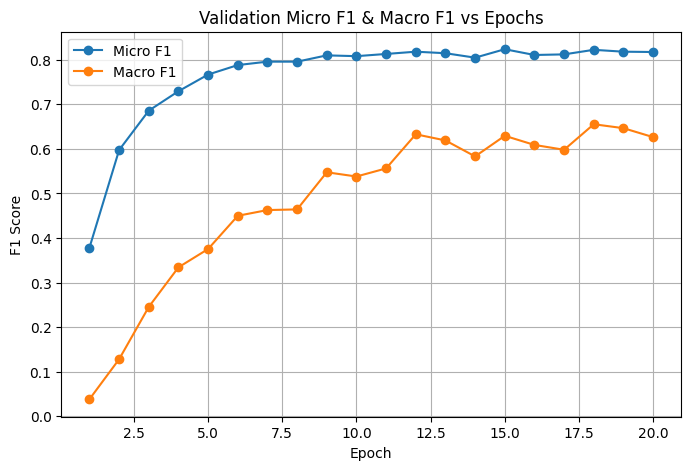

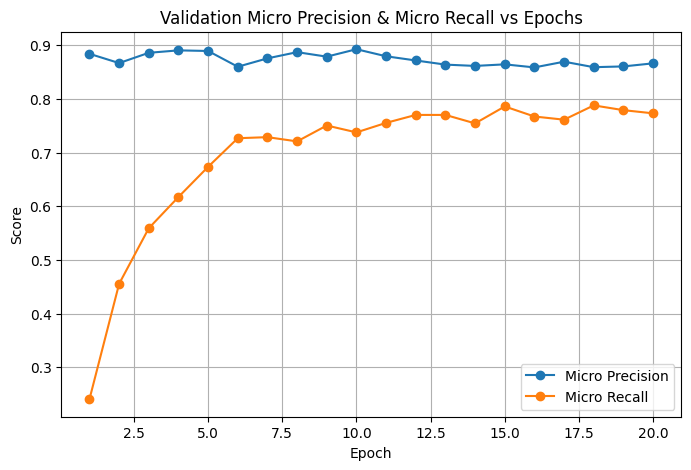

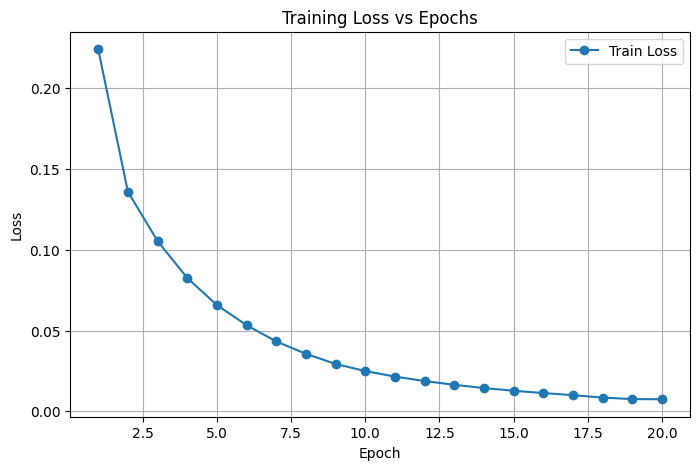

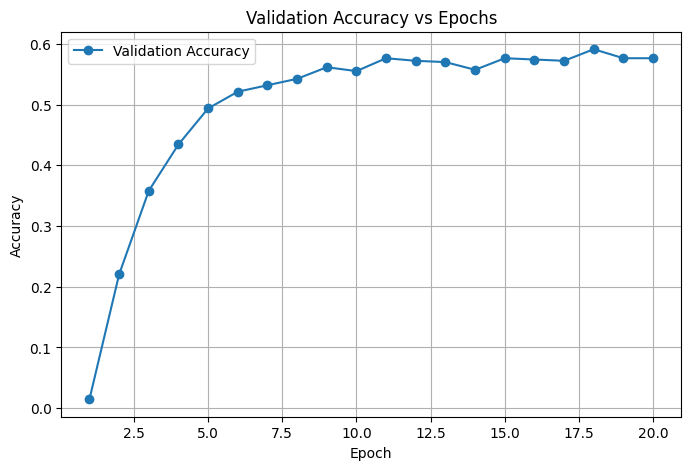

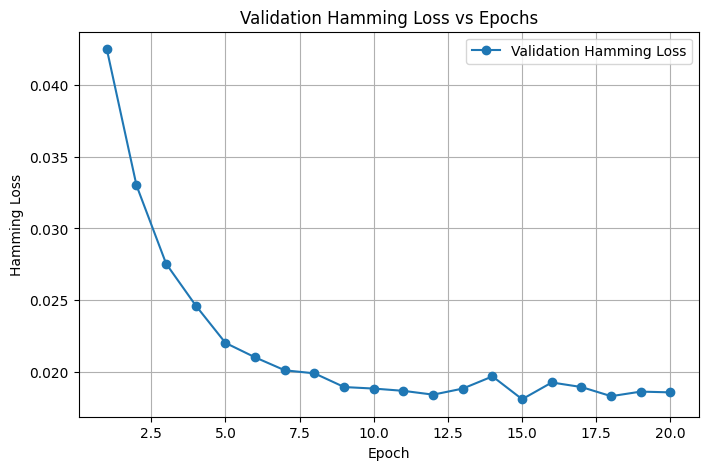


All steps completed. Final model corresponds to epoch 15 with best Hamming loss = 0.018114406779661016


In [ ]:
print("\nCheckpoint 16.1: Plotting metrics vs epochs.")

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, val_micro_f1s, marker="o", label="Micro F1")
plt.plot(epochs_range, val_macro_f1s, marker="o", label="Macro F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation Micro F1 & Macro F1 vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, val_micro_precisions, marker="o", label="Micro Precision")
plt.plot(epochs_range, val_micro_recalls, marker="o", label="Micro Recall")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Micro Precision & Micro Recall vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_losses, marker="o", label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, val_accuracies, marker="o", label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs_range, val_hamming_losses, marker="o", label="Validation Hamming Loss")
plt.xlabel("Epoch")
plt.ylabel("Hamming Loss")
plt.title("Validation Hamming Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

print("\nAll steps completed. Final model corresponds to epoch", best_epoch,
      "with best Hamming loss =", best_hamming_loss)


## **Step 17 — Baseline Model: TF-IDF + One-vs-Rest Logistic Regression**

This cell builds a strong classical baseline to compare against ClinicalBERT.  
It converts medical transcriptions into numerical TF-IDF vectors and trains a **One-vs-Rest Logistic Regression** classifier for multi-label prediction.

Key steps performed:
- **Text Cleaning:** Apply the same cleaning function used earlier for consistency.  
- **TF-IDF Vectorization:** Transform raw text into sparse unigram–bigram TF-IDF features (max 50k features).  
- **One-vs-Rest Logistic Regression:** Train one binary classifier per medical specialty label.  
- **Validation Metrics:** Compute Micro F1, Macro F1, Precision, Recall, Accuracy, and Hamming Loss to provide a fair comparison with BERT-like models.

This baseline helps quantify how much performance improvement the deep learning models offer beyond traditional linear methods.


In [35]:
print("\nSTEP 17: Building a baseline with TF-IDF + Logistic Regression (multi-label).")

print("Checkpoint 17.1: Cleaning train and validation texts for TF-IDF.")

X_train_clean = [clean_medical_text(t) for t in X_train_raw]
X_val_clean   = [clean_medical_text(t) for t in X_val_raw]

print("Example cleaned training text:")
print(X_train_clean[0][:300], "...\n")

print("Checkpoint 17.2: Fitting TF-IDF vectorizer on training data.")

tfidf_vectorizer = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    min_df=2,
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_clean)
X_val_tfidf   = tfidf_vectorizer.transform(X_val_clean)

print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_val_tfidf shape:", X_val_tfidf.shape)

print("\nCheckpoint 17.3: Training OneVsRest Logistic Regression (multi-label).")

log_reg_base = LogisticRegression(
    max_iter=1000,
)

baseline_clf = OneVsRestClassifier(log_reg_base, n_jobs=-1)

baseline_clf.fit(X_train_tfidf, y_train)

print("Baseline Logistic Regression model trained.")

print("\nCheckpoint 17.4: Evaluating Logistic Regression baseline on validation set.")

y_val_pred_baseline = baseline_clf.predict(X_val_tfidf)

baseline_micro_f1 = f1_score(y_val, y_val_pred_baseline, average="micro", zero_division=0)
baseline_macro_f1 = f1_score(y_val, y_val_pred_baseline, average="macro", zero_division=0)
baseline_micro_precision = precision_score(y_val, y_val_pred_baseline, average="micro", zero_division=0)
baseline_micro_recall    = recall_score(y_val, y_val_pred_baseline, average="micro", zero_division=0)
baseline_accuracy        = accuracy_score(y_val, y_val_pred_baseline)
baseline_hamming_loss    = hamming_loss(y_val, y_val_pred_baseline)

print("\n=== Logistic Regression + TF-IDF Baseline Metrics (Validation) ===")
print(f"Micro F1        : {baseline_micro_f1:.4f}")
print(f"Macro F1        : {baseline_macro_f1:.4f}")
print(f"Micro Precision : {baseline_micro_precision:.4f}")
print(f"Micro Recall    : {baseline_micro_recall:.4f}")
print(f"Accuracy        : {baseline_accuracy:.4f}")
print(f"Hamming Loss    : {baseline_hamming_loss:.4f}")

print("\n=== COMPARISON SUMMARY (Baseline vs BERT) ===")
print("BERT (best epoch):")
print(f"  Hamming Loss    : {best_hamming_loss:.4f}")
if len(val_micro_f1s) > 0:
    print(f"  Micro F1        : {max(val_micro_f1s):.4f} (max over epochs)")
    print(f"  Macro F1        : {max(val_macro_f1s):.4f} (max over epochs)")

print("\nLogistic Regression + TF-IDF Baseline:")
print(f"  Hamming Loss    : {baseline_hamming_loss:.4f}")
print(f"  Micro F1        : {baseline_micro_f1:.4f}")
print(f"  Macro F1        : {baseline_macro_f1:.4f}")



STEP 17: Building a baseline with TF-IDF + Logistic Regression (multi-label).
Checkpoint 17.1: Cleaning train and validation texts for TF-IDF.
Example cleaned training text:
prostate brachytherapy - prostate i-125 implantation,this patient will be treated to the prostate with ultrasound-guided i-125 seed implantation. the original consultation and treatment planning will be separately performed. at the time of the implantation, special coordination will be required. ste ...

Checkpoint 17.2: Fitting TF-IDF vectorizer on training data.
X_train_tfidf shape: (1885, 50000)
X_val_tfidf shape: (472, 50000)

Checkpoint 17.3: Training OneVsRest Logistic Regression (multi-label).
Baseline Logistic Regression model trained.

Checkpoint 17.4: Evaluating Logistic Regression baseline on validation set.

=== Logistic Regression + TF-IDF Baseline Metrics (Validation) ===
Micro F1        : 0.5463
Macro F1        : 0.1384
Micro Precision : 0.9311
Micro Recall    : 0.3866
Accuracy        : 0.1695
Hammi

## **Step 18 — Performance Comparison: ClinicalBERT vs TF-IDF + Logistic Regression**

This cell summarizes and visualizes the performance difference between the deep-learning model (ClinicalBERT) and the classical baseline (TF-IDF + One-vs-Rest Logistic Regression).  
Using the **best epoch** from BERT (based on minimum Hamming Loss), we extract its Micro F1, Macro F1, and Hamming Loss and place them side-by-side with the baseline metrics.

A comparison table is created first, followed by a grouped bar plot for intuitive visual interpretation.  
This step highlights how much improvement the ClinicalBERT model offers over traditional linear methods for multi-label medical text classification.



STEP 18: Creating comparison table and bar plot for BERT vs Logistic baseline.

=== Comparison: ClinicalBERT vs Logistic Regression + TF-IDF ===
      Metric  ClinicalBERT  LogReg_TFIDF
    Micro F1      0.823347      0.546341
    Macro F1      0.629186      0.138351
Hamming Loss      0.018114      0.034481


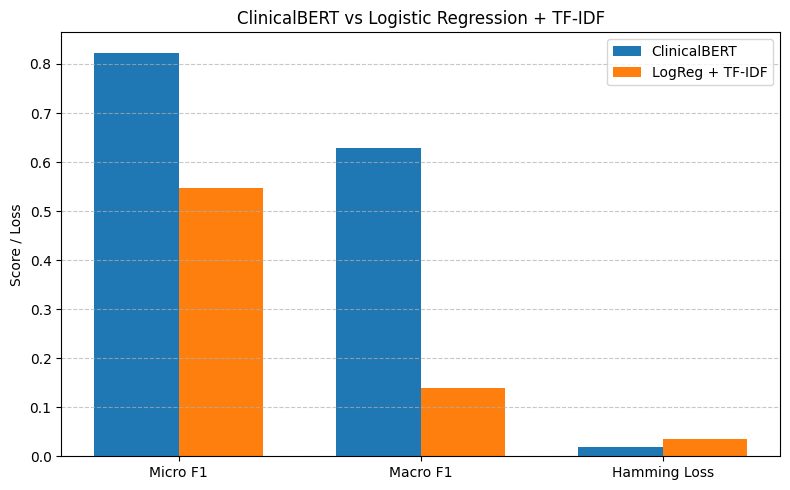

In [ ]:
print("\nSTEP 18: Creating comparison table and bar plot for BERT vs Logistic baseline.")

if best_epoch is not None and best_epoch > 0:
    bert_best_micro_f1 = val_micro_f1s[best_epoch - 1]
    bert_best_macro_f1 = val_macro_f1s[best_epoch - 1]
else:
    bert_best_micro_f1 = val_micro_f1s[-1]
    bert_best_macro_f1 = val_macro_f1s[-1]

comparison_df = pd.DataFrame({
    "Metric": ["Micro F1", "Macro F1", "Hamming Loss"],
    "ClinicalBERT": [
        bert_best_micro_f1,
        bert_best_macro_f1,
        best_hamming_loss,
    ],
    "LogReg_TFIDF": [
        baseline_micro_f1,
        baseline_macro_f1,
        baseline_hamming_loss,
    ],
})

print("\n=== Comparison: ClinicalBERT vs Logistic Regression + TF-IDF ===")
print(comparison_df.to_string(index=False))

metrics = comparison_df["Metric"].values
bert_values = comparison_df["ClinicalBERT"].values
logreg_values = comparison_df["LogReg_TFIDF"].values

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, bert_values, width, label="ClinicalBERT")
plt.bar(x + width/2, logreg_values, width, label="LogReg + TF-IDF")

plt.xticks(x, metrics)
plt.ylabel("Score / Loss")
plt.title("ClinicalBERT vs Logistic Regression + TF-IDF")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

## **Step 19 — Multi-Level Summarization for Long Clinical Notes (Model C)**

This block implements a controlled hierarchical summarization pipeline using *ClinicalT5* to compress only those transcriptions whose ClinicalBERT token length exceeds 512. Short transcriptions (≤512 tokens) are **not summarized**—only cleaned.  

The process includes:
- Loading the ClinicalT5 model for seq2seq summarization.
- A one-round hierarchical summarizer that chunks long text and summarizes each chunk.
- A repeat-until-compressed function that applies multiple rounds (up to 4) until the BERT token length falls below 512.
- Tracking per-sample statistics: whether summarization occurred, how many rounds were needed, original vs summarized token lengths, and percentage reduction.
- Printing progress summaries after every 10% of processed samples to monitor compression effectiveness.
- Adding the summarized text back to `final_df` and saving a clean 42-column CSV (`transcription_raw`, `summarized_for_bert`, and 40 multi-label targets).
- Finally, reporting global statistics on how much summarization reduced token lengths.

This summarized dataset will be used in Step 20 to train **Model C**, a ClinicalBERT classifier operating on compressed hierarchical summaries.


In [33]:
print("\nSTEP 19: Preparing summarization-based inputs using ClinicalT5.")

clinical_t5_model_name = "hossboll/clinical-t5"

print("Checkpoint 19.1: Loading ClinicalT5 summarization model...")
summarizer_tokenizer = AutoTokenizer.from_pretrained(clinical_t5_model_name)
summarizer_model = AutoModelForSeq2SeqLM.from_pretrained(clinical_t5_model_name).to(device)
summarizer_model.eval()

def count_tokens(text: str) -> int:
    """
    Counts tokens using ClinicalBERT tokenizer EXACTLY the same way as the model.
    No truncation, so we get REAL token length.
    """
    return len(
        tokenizer.encode(
            str(text),
            add_special_tokens=True,
            truncation=False
        )
    )


def one_round_t5_hierarchical(
    text: str,
    tokenizer,
    model,
    chunk_input_tokens: int = 512,
    chunk_summary_tokens: int = 128,
    final_summary_tokens: int = 256
) -> str:
    """
    One hierarchical T5 summarization round.
    """
    if not isinstance(text, str) or not text.strip():
        return ""

    full_ids = tokenizer.encode(text, truncation=False, add_special_tokens=True)

    if len(full_ids) <= chunk_input_tokens:
        input_ids = torch.tensor([full_ids]).to(device)
        with torch.no_grad():
            summary_ids = model.generate(
                input_ids,
                max_length=final_summary_tokens,
                num_beams=4,
                early_stopping=True,
            )
        return tokenizer.decode(summary_ids[0], skip_special_tokens=True).strip()

    chunks = []
    for i in range(0, len(full_ids), chunk_input_tokens):
        chunk_ids = full_ids[i:i + chunk_input_tokens]
        chunk_text = tokenizer.decode(chunk_ids, skip_special_tokens=True)
        chunks.append(chunk_text)

    chunk_summaries = []
    for chunk_text in chunks:
        if not chunk_text.strip():
            continue
        chunk_input_ids = tokenizer.encode(
            chunk_text,
            truncation=True,
            max_length=chunk_input_tokens,
            return_tensors="pt",
        ).to(device)
        with torch.no_grad():
            chunk_summary_ids = model.generate(
                chunk_input_ids,
                max_length=chunk_summary_tokens,
                num_beams=4,
                early_stopping=True,
            )
        chunk_summary = tokenizer.decode(chunk_summary_ids[0], skip_special_tokens=True).strip()
        if chunk_summary:
            chunk_summaries.append(chunk_summary)

    if not chunk_summaries:
        return text

    intermediate = " ".join(chunk_summaries)

    final_input_ids = tokenizer.encode(
        intermediate,
        truncation=True,
        max_length=chunk_input_tokens,
        return_tensors="pt",
    ).to(device)

    with torch.no_grad():
        final_summary_ids = model.generate(
            final_input_ids,
            max_length=final_summary_tokens,
            num_beams=4,
            early_stopping=True,
        )

    return tokenizer.decode(final_summary_ids[0], skip_special_tokens=True).strip()


def summarize_until_bert_leq_512(
    text: str,
    bert_tokenizer,
    t5_tokenizer,
    t5_model,
    bert_max_len: int = 512,
    max_rounds: int = 4,
):
    """
    Multi-level summarization:
    - Only called for texts whose BERT length > bert_max_len.
    - Repeatedly apply one_round_t5_hierarchical until
      BERT token length <= bert_max_len or max_rounds is reached.
    Returns (final_text, rounds_used).
    """
    if not isinstance(text, str) or not text.strip():
        return "", 0

    current_text = text
    rounds_used = 0

    for r in range(max_rounds):
        bert_len = len(
            bert_tokenizer.encode(
                current_text,
                add_special_tokens=True,
                truncation=False
            )
        )
        if bert_len <= bert_max_len:
            return current_text, rounds_used

        current_text = one_round_t5_hierarchical(
            current_text,
            tokenizer=t5_tokenizer,
            model=t5_model,
            chunk_input_tokens=512,
            chunk_summary_tokens=128,
            final_summary_tokens=256,
        )
        rounds_used += 1

    return current_text, rounds_used


print("Checkpoint 19.2: Building summarized_for_bert (summarize only if BERT tokens > 512).")

original_bert_lengths = []
summarized_bert_lengths = []
summarized_texts = []
summarization_log = []

total_samples = len(final_df)
progress_chunk = max(1, total_samples // 10)

def print_progress_summary(done, total, orig_lens, summ_lens):
    """Print a small summarization summary for the processed subset."""
    import numpy as np
    orig = np.array(orig_lens)
    summ = np.array(summ_lens)

    print("\n----- Summarization summary after "
          f"{done}/{total} samples ({100.0*done/total:.1f}%) -----")
    print(f"Avg original tokens (processed):   {orig.mean():.2f}")
    print(f"Avg summarized tokens (processed): {summ.mean():.2f}")
    print(f"Avg reduction (processed):         {(orig - summ).mean():.2f}")
    print(f"Avg % reduction (processed):       "
          f"{(100.0 * (orig - summ) / np.where(orig==0,1,orig)).mean():.2f}%")
    print(f"Count original > {MAX_LEN}:        {(orig > MAX_LEN).sum()}")
    print(f"Count summarized > {MAX_LEN}:      {(summ > MAX_LEN).sum()}")
    print("------------------------------------------------------\n")

print(f"Summarizing long transcriptions (total = {total_samples}) ...")

for idx, text in enumerate(tqdm(final_df["transcription_raw"], desc="Summarizing long transcriptions")):
    raw_text = str(text)
    bert_len_raw = count_tokens(raw_text)
    original_bert_lengths.append(bert_len_raw)

    if bert_len_raw <= MAX_LEN:
        cleaned = clean_medical_text(raw_text)
        summarized_texts.append(cleaned)

        bert_len_summ = count_tokens(cleaned)
        summarized_bert_lengths.append(bert_len_summ)

        summarization_log.append({
            "index": idx,
            "was_summarized": False,
            "rounds_used": 0,
            "orig_tokens": bert_len_raw,
            "summ_tokens": bert_len_summ,
        })

    else:
        summary_text, rounds_used = summarize_until_bert_leq_512(
            raw_text,
            bert_tokenizer=tokenizer,
            t5_tokenizer=summarizer_tokenizer,
            t5_model=summarizer_model,
            bert_max_len=MAX_LEN,
            max_rounds=4,
        )
        cleaned = clean_medical_text(summary_text)
        summarized_texts.append(cleaned)

        bert_len_summ = count_tokens(cleaned)
        summarized_bert_lengths.append(bert_len_summ)

        summarization_log.append({
            "index": idx,
            "was_summarized": True,
            "rounds_used": rounds_used,
            "orig_tokens": bert_len_raw,
            "summ_tokens": bert_len_summ,
        })

    done = idx + 1
    if (done % progress_chunk == 0) or (done == total_samples):
        print_progress_summary(done, total_samples,
                               original_bert_lengths,
                               summarized_bert_lengths)

final_df["summarized_for_bert"] = summarized_texts
final_df["orig_bert_len"] = original_bert_lengths
final_df["summ_bert_len"] = summarized_bert_lengths
final_df["len_reduction"] = final_df["orig_bert_len"] - final_df["summ_bert_len"]
final_df["len_reduction_pct"] = (
    100.0 * final_df["len_reduction"] / final_df["orig_bert_len"].replace(0, 1)
)

print("Checkpoint 19.3: Example original vs summarized text/snippets:")
print("Original (snippet):", final_df["transcription_raw"].iloc[0][:300], "...")
print("\nSummarized+cleaned (snippet):", final_df["summarized_for_bert"].iloc[0][:300], "...")

print("\nSTEP 19.4: Saving summarized text with multi-label targets to CSV.")

label_columns = list(mlb.classes_)

cols_to_save = ["transcription_raw", "summarized_for_bert"] + label_columns
summarized_df_to_save = final_df[cols_to_save].copy()

output_csv_path = "mtsamples_hierarchical_summarized_multilabel.csv"
summarized_df_to_save.to_csv(output_csv_path, index=False)

print(f"Saved summarized dataset to: {output_csv_path}")
print("Shape of saved data:", summarized_df_to_save.shape)
print("Columns:", summarized_df_to_save.columns.tolist())


print("\n===== SUMMARIZATION EFFECTIVENESS (BERT TOKEN SPACE) =====")
print(f"Total samples: {len(final_df)}")

print(f"Average original length:   {final_df['orig_bert_len'].mean():.2f}")
print(f"Average summarized length: {final_df['summ_bert_len'].mean():.2f}")
print(f"Average reduction tokens:  {final_df['len_reduction'].mean():.2f}")
print(f"Average % reduction:       {final_df['len_reduction_pct'].mean():.2f}%")

print(f"\nCount with original > {MAX_LEN}: {sum(final_df['orig_bert_len'] > MAX_LEN)}")
print(f"Count with summarized > {MAX_LEN}: {sum(final_df['summ_bert_len'] > MAX_LEN)}")

print(f"\nMax original length:       {final_df['orig_bert_len'].max()}")
print(f"Max summarized length:     {final_df['summ_bert_len'].max()}")
print(f"Min summarized length:     {final_df['summ_bert_len'].min()}")

print("\n(For notes with ≤512 BERT tokens, only cleaning was applied; no summarization.)")


STEP 19: Preparing summarization-based inputs using ClinicalT5.
Checkpoint 19.1: Loading ClinicalT5 summarization model...
Checkpoint 19.2: Building summarized_for_bert (summarize only if BERT tokens > 512).
Summarizing long transcriptions (total = 2357) ...


Summarizing long transcriptions:  10%|▉         | 235/2357 [10:44<1:16:33,  2.16s/it]


----- Summarization summary after 235/2357 samples (10.0%) -----
Avg original tokens (processed):   806.69
Avg summarized tokens (processed): 149.57
Avg reduction (processed):         657.12
Avg % reduction (processed):       66.37%
Count original > 512:        171
Count summarized > 512:      0
------------------------------------------------------



Summarizing long transcriptions:  20%|█▉        | 469/2357 [19:57<1:19:42,  2.53s/it]


----- Summarization summary after 470/2357 samples (19.9%) -----
Avg original tokens (processed):   776.93
Avg summarized tokens (processed): 161.93
Avg reduction (processed):         615.00
Avg % reduction (processed):       61.64%
Count original > 512:        317
Count summarized > 512:      0
------------------------------------------------------



Summarizing long transcriptions:  30%|██▉       | 705/2357 [27:04<1:38:50,  3.59s/it]


----- Summarization summary after 705/2357 samples (29.9%) -----
Avg original tokens (processed):   721.82
Avg summarized tokens (processed): 171.31
Avg reduction (processed):         550.51
Avg % reduction (processed):       55.43%
Count original > 512:        429
Count summarized > 512:      0
------------------------------------------------------



Summarizing long transcriptions:  40%|███▉      | 940/2357 [35:33<31:52,  1.35s/it]


----- Summarization summary after 940/2357 samples (39.9%) -----
Avg original tokens (processed):   715.93
Avg summarized tokens (processed): 170.98
Avg reduction (processed):         544.95
Avg % reduction (processed):       54.38%
Count original > 512:        562
Count summarized > 512:      0
------------------------------------------------------



Summarizing long transcriptions:  50%|████▉     | 1175/2357 [47:23<1:06:28,  3.37s/it]


----- Summarization summary after 1175/2357 samples (49.9%) -----
Avg original tokens (processed):   759.27
Avg summarized tokens (processed): 166.02
Avg reduction (processed):         593.25
Avg % reduction (processed):       57.71%
Count original > 512:        744
Count summarized > 512:      0
------------------------------------------------------



Summarizing long transcriptions:  60%|█████▉    | 1410/2357 [58:15<48:20,  3.06s/it]


----- Summarization summary after 1410/2357 samples (59.8%) -----
Avg original tokens (processed):   772.38
Avg summarized tokens (processed): 162.81
Avg reduction (processed):         609.57
Avg % reduction (processed):       59.37%
Count original > 512:        918
Count summarized > 512:      0
------------------------------------------------------



Summarizing long transcriptions:  70%|██████▉   | 1645/2357 [1:07:09<22:36,  1.91s/it]


----- Summarization summary after 1645/2357 samples (69.8%) -----
Avg original tokens (processed):   763.17
Avg summarized tokens (processed): 165.57
Avg reduction (processed):         597.60
Avg % reduction (processed):       58.96%
Count original > 512:        1065
Count summarized > 512:      0
------------------------------------------------------



Summarizing long transcriptions:  80%|███████▉  | 1879/2357 [1:15:00<21:03,  2.64s/it]


----- Summarization summary after 1880/2357 samples (79.8%) -----
Avg original tokens (processed):   750.15
Avg summarized tokens (processed): 168.87
Avg reduction (processed):         581.27
Avg % reduction (processed):       57.83%
Count original > 512:        1194
Count summarized > 512:      0
------------------------------------------------------



Summarizing long transcriptions:  90%|████████▉ | 2115/2357 [1:24:49<10:50,  2.69s/it]


----- Summarization summary after 2115/2357 samples (89.7%) -----
Avg original tokens (processed):   752.98
Avg summarized tokens (processed): 167.79
Avg reduction (processed):         585.19
Avg % reduction (processed):       58.04%
Count original > 512:        1348
Count summarized > 512:      0
------------------------------------------------------



Summarizing long transcriptions: 100%|█████████▉| 2349/2357 [1:32:12<00:07,  1.06it/s]


----- Summarization summary after 2350/2357 samples (99.7%) -----
Avg original tokens (processed):   742.38
Avg summarized tokens (processed): 170.04
Avg reduction (processed):         572.34
Avg % reduction (processed):       56.90%
Count original > 512:        1469
Count summarized > 512:      0
------------------------------------------------------



Summarizing long transcriptions: 100%|██████████| 2357/2357 [1:32:17<00:00,  2.35s/it]



----- Summarization summary after 2357/2357 samples (100.0%) -----
Avg original tokens (processed):   741.40
Avg summarized tokens (processed): 170.26
Avg reduction (processed):         571.13
Avg % reduction (processed):       56.81%
Count original > 512:        1471
Count summarized > 512:      0
------------------------------------------------------

Checkpoint 19.3: Example original vs summarized text/snippets:
Original (snippet): 1.  Odynophagia.,2.  Dysphagia.,3.  Gastroesophageal reflux disease rule out stricture.,POSTOPERATIVE DIAGNOSES:,1.  Antral gastritis.,2.  Hiatal hernia.,PROCEDURE PERFORMED:  EGD with photos and biopsies.,GROSS FINDINGS:  This is a 75-year-old female who presents with difficulty swallowing, occasio ...

Summarized+cleaned (snippet): 1. odynophagia.,2. dysphagia.,3. gastroesophageal reflux disease rule out stricture.,postoperative diagnoses:,1. antral gastritis.,2. hiatal hernia.,procedure performed: egd with photos and biopsies.,gross findings: this is 

## **Step 20 — ClinicalBERT on Hierarchically Summarized Notes (Model C)**

This step trains **Model C**, a ClinicalBERT classifier that operates on the compressed, multi-level-summarized transcriptions generated in Step 19.  
We load the saved 42-column CSV (raw text, summarized text, and multi-label targets), recreate the train/validation split, and feed the *summarized_for_bert* text directly into a dataset class designed for pre-summarized inputs.

Key components of this block:
- **Dataset reconstruction:** Load summarized text + labels or fall back to cleaning raw text if necessary.
- **Model setup:** A fresh instance of ClinicalBERT with the same hyperparameters, training loop, and early-stopping logic used earlier.
- **Metric tracking:** Per-epoch Micro F1, Macro F1, Precision, Recall, Accuracy, and Hamming Loss.
- **Visualization:** Multiple plots showing how Model C’s performance evolves through training.
- **Baseline comparison:** Final evaluation against the Logistic Regression + TF-IDF baseline to measure the impact of multi-level summarization.

This section evaluates whether summarization improves (or harms) downstream multi-label clinical text classification under the same settings as the original model.



STEP 20: Training ClinicalBERT on multi-level hierarchical summarized text (Model C).
Train/Val variables already exist in memory. Using existing split.
Checkpoint 20.1: Creating train/val datasets & loaders for summarized text (Model C).
Number of training batches (summarized): 236
Number of validation batches (summarized): 59

Checkpoint 20.2: Initializing ClinicalBERT model for summarized input (Model C).

Checkpoint 20.3: Starting training for Model C (summarized text).

========== [Model C] Epoch 1/25 ==========


Training: 100%|██████████| 236/236 [03:04<00:00,  1.28it/s]


[Model C] Train Loss: 0.2183


Validation: 100%|██████████| 59/59 [00:13<00:00,  4.25it/s]


[Model C] Validation Metrics:
  micro_f1: 0.3857
  macro_f1: 0.0386
  micro_precision: 0.9118
  micro_recall: 0.2446
  accuracy: 0.0191
  hamming_loss: 0.0418
** [Model C] New best Hamming loss: 0.0418 at epoch 1. **

========== [Model C] Epoch 2/25 ==========


Training: 100%|██████████| 236/236 [03:03<00:00,  1.28it/s]


[Model C] Train Loss: 0.1339


Validation: 100%|██████████| 59/59 [00:13<00:00,  4.25it/s]


[Model C] Validation Metrics:
  micro_f1: 0.6217
  macro_f1: 0.1377
  micro_precision: 0.8748
  micro_recall: 0.4822
  accuracy: 0.2288
  hamming_loss: 0.0315
** [Model C] New best Hamming loss: 0.0315 at epoch 2. **

========== [Model C] Epoch 3/25 ==========


Training: 100%|██████████| 236/236 [03:03<00:00,  1.28it/s]


[Model C] Train Loss: 0.1025


Validation: 100%|██████████| 59/59 [00:13<00:00,  4.25it/s]


[Model C] Validation Metrics:
  micro_f1: 0.6981
  macro_f1: 0.2471
  micro_precision: 0.9003
  micro_recall: 0.5700
  accuracy: 0.3644
  hamming_loss: 0.0265
** [Model C] New best Hamming loss: 0.0265 at epoch 3. **

========== [Model C] Epoch 4/25 ==========


Training: 100%|██████████| 236/236 [03:03<00:00,  1.28it/s]


[Model C] Train Loss: 0.0801


Validation: 100%|██████████| 59/59 [00:13<00:00,  4.25it/s]


[Model C] Validation Metrics:
  micro_f1: 0.7648
  macro_f1: 0.3370
  micro_precision: 0.9021
  micro_recall: 0.6637
  accuracy: 0.4576
  hamming_loss: 0.0219
** [Model C] New best Hamming loss: 0.0219 at epoch 4. **

========== [Model C] Epoch 5/25 ==========


Training: 100%|██████████| 236/236 [03:03<00:00,  1.28it/s]


[Model C] Train Loss: 0.0636


Validation: 100%|██████████| 59/59 [00:13<00:00,  4.25it/s]


[Model C] Validation Metrics:
  micro_f1: 0.7708
  macro_f1: 0.3870
  micro_precision: 0.8870
  micro_recall: 0.6815
  accuracy: 0.4979
  hamming_loss: 0.0218
** [Model C] New best Hamming loss: 0.0218 at epoch 5. **

========== [Model C] Epoch 6/25 ==========


Training: 100%|██████████| 236/236 [03:03<00:00,  1.28it/s]


[Model C] Train Loss: 0.0515


Validation: 100%|██████████| 59/59 [00:13<00:00,  4.25it/s]


[Model C] Validation Metrics:
  micro_f1: 0.7976
  macro_f1: 0.4381
  micro_precision: 0.8926
  micro_recall: 0.7209
  accuracy: 0.5169
  hamming_loss: 0.0197
** [Model C] New best Hamming loss: 0.0197 at epoch 6. **

========== [Model C] Epoch 7/25 ==========


Training: 100%|██████████| 236/236 [03:04<00:00,  1.28it/s]


[Model C] Train Loss: 0.0423


Validation: 100%|██████████| 59/59 [00:13<00:00,  4.24it/s]


[Model C] Validation Metrics:
  micro_f1: 0.7924
  macro_f1: 0.4522
  micro_precision: 0.8797
  micro_recall: 0.7209
  accuracy: 0.5148
  hamming_loss: 0.0203
[Model C] No improvement in Hamming loss. Patience 1/5.

========== [Model C] Epoch 8/25 ==========


Training: 100%|██████████| 236/236 [03:04<00:00,  1.28it/s]


[Model C] Train Loss: 0.0351


Validation: 100%|██████████| 59/59 [00:13<00:00,  4.25it/s]


[Model C] Validation Metrics:
  micro_f1: 0.7981
  macro_f1: 0.5046
  micro_precision: 0.8848
  micro_recall: 0.7268
  accuracy: 0.5297
  hamming_loss: 0.0198
[Model C] No improvement in Hamming loss. Patience 2/5.

========== [Model C] Epoch 9/25 ==========


Training: 100%|██████████| 236/236 [03:03<00:00,  1.28it/s]


[Model C] Train Loss: 0.0294


Validation: 100%|██████████| 59/59 [00:13<00:00,  4.25it/s]


[Model C] Validation Metrics:
  micro_f1: 0.8135
  macro_f1: 0.5799
  micro_precision: 0.8760
  micro_recall: 0.7594
  accuracy: 0.5636
  hamming_loss: 0.0187
** [Model C] New best Hamming loss: 0.0187 at epoch 9. **

========== [Model C] Epoch 10/25 ==========


Training: 100%|██████████| 236/236 [03:04<00:00,  1.28it/s]


[Model C] Train Loss: 0.0252


Validation: 100%|██████████| 59/59 [00:13<00:00,  4.24it/s]


[Model C] Validation Metrics:
  micro_f1: 0.8109
  macro_f1: 0.5571
  micro_precision: 0.8846
  micro_recall: 0.7485
  accuracy: 0.5636
  hamming_loss: 0.0187
[Model C] No improvement in Hamming loss. Patience 1/5.

========== [Model C] Epoch 11/25 ==========


Training: 100%|██████████| 236/236 [03:04<00:00,  1.28it/s]


[Model C] Train Loss: 0.0215


Validation: 100%|██████████| 59/59 [00:13<00:00,  4.21it/s]


[Model C] Validation Metrics:
  micro_f1: 0.8183
  macro_f1: 0.5699
  micro_precision: 0.8871
  micro_recall: 0.7594
  accuracy: 0.5742
  hamming_loss: 0.0181
** [Model C] New best Hamming loss: 0.0181 at epoch 11. **

========== [Model C] Epoch 12/25 ==========


Training: 100%|██████████| 236/236 [03:03<00:00,  1.28it/s]


[Model C] Train Loss: 0.0183


Validation: 100%|██████████| 59/59 [00:13<00:00,  4.25it/s]


[Model C] Validation Metrics:
  micro_f1: 0.8221
  macro_f1: 0.6233
  micro_precision: 0.8700
  micro_recall: 0.7791
  accuracy: 0.5784
  hamming_loss: 0.0181
[Model C] No improvement in Hamming loss. Patience 1/5.

========== [Model C] Epoch 13/25 ==========


Training: 100%|██████████| 236/236 [03:03<00:00,  1.28it/s]


[Model C] Train Loss: 0.0161


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.21it/s]


[Model C] Validation Metrics:
  micro_f1: 0.8243
  macro_f1: 0.6015
  micro_precision: 0.8689
  micro_recall: 0.7840
  accuracy: 0.5742
  hamming_loss: 0.0180
** [Model C] New best Hamming loss: 0.0180 at epoch 13. **

========== [Model C] Epoch 14/25 ==========


Training: 100%|██████████| 236/236 [03:04<00:00,  1.28it/s]


[Model C] Train Loss: 0.0139


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.20it/s]


[Model C] Validation Metrics:
  micro_f1: 0.8254
  macro_f1: 0.6245
  micro_precision: 0.8840
  micro_recall: 0.7742
  accuracy: 0.5784
  hamming_loss: 0.0176
** [Model C] New best Hamming loss: 0.0176 at epoch 14. **

========== [Model C] Epoch 15/25 ==========


Training: 100%|██████████| 236/236 [03:03<00:00,  1.28it/s]


[Model C] Train Loss: 0.0121


Validation: 100%|██████████| 59/59 [00:13<00:00,  4.22it/s]


[Model C] Validation Metrics:
  micro_f1: 0.8273
  macro_f1: 0.6284
  micro_precision: 0.8782
  micro_recall: 0.7821
  accuracy: 0.5847
  hamming_loss: 0.0175
** [Model C] New best Hamming loss: 0.0175 at epoch 15. **

========== [Model C] Epoch 16/25 ==========


Training: 100%|██████████| 236/236 [03:03<00:00,  1.28it/s]


[Model C] Train Loss: 0.0104


Validation: 100%|██████████| 59/59 [00:13<00:00,  4.24it/s]


[Model C] Validation Metrics:
  micro_f1: 0.8307
  macro_f1: 0.6426
  micro_precision: 0.8746
  micro_recall: 0.7909
  accuracy: 0.5890
  hamming_loss: 0.0173
** [Model C] New best Hamming loss: 0.0173 at epoch 16. **

========== [Model C] Epoch 17/25 ==========


Training: 100%|██████████| 236/236 [03:04<00:00,  1.28it/s]


[Model C] Train Loss: 0.0096


Validation: 100%|██████████| 59/59 [00:13<00:00,  4.24it/s]


[Model C] Validation Metrics:
  micro_f1: 0.8319
  macro_f1: 0.6465
  micro_precision: 0.8836
  micro_recall: 0.7860
  accuracy: 0.5932
  hamming_loss: 0.0171
** [Model C] New best Hamming loss: 0.0171 at epoch 17. **

========== [Model C] Epoch 18/25 ==========


Training: 100%|██████████| 236/236 [03:03<00:00,  1.28it/s]


[Model C] Train Loss: 0.0091


Validation: 100%|██████████| 59/59 [00:13<00:00,  4.24it/s]


[Model C] Validation Metrics:
  micro_f1: 0.8299
  macro_f1: 0.6353
  micro_precision: 0.8841
  micro_recall: 0.7821
  accuracy: 0.5953
  hamming_loss: 0.0172
[Model C] No improvement in Hamming loss. Patience 1/5.

========== [Model C] Epoch 19/25 ==========


Training: 100%|██████████| 236/236 [03:04<00:00,  1.28it/s]


[Model C] Train Loss: 0.0078


Validation: 100%|██████████| 59/59 [00:13<00:00,  4.25it/s]


[Model C] Validation Metrics:
  micro_f1: 0.8284
  macro_f1: 0.6366
  micro_precision: 0.8673
  micro_recall: 0.7929
  accuracy: 0.5890
  hamming_loss: 0.0176
[Model C] No improvement in Hamming loss. Patience 2/5.

========== [Model C] Epoch 20/25 ==========


Training: 100%|██████████| 236/236 [03:03<00:00,  1.28it/s]


[Model C] Train Loss: 0.0071


Validation: 100%|██████████| 59/59 [00:13<00:00,  4.24it/s]


[Model C] Validation Metrics:
  micro_f1: 0.8308
  macro_f1: 0.6455
  micro_precision: 0.8798
  micro_recall: 0.7870
  accuracy: 0.5996
  hamming_loss: 0.0172
[Model C] No improvement in Hamming loss. Patience 3/5.

========== [Model C] Epoch 21/25 ==========


Training: 100%|██████████| 236/236 [03:03<00:00,  1.28it/s]


[Model C] Train Loss: 0.0063


Validation: 100%|██████████| 59/59 [00:13<00:00,  4.24it/s]


[Model C] Validation Metrics:
  micro_f1: 0.8346
  macro_f1: 0.6266
  micro_precision: 0.8798
  micro_recall: 0.7939
  accuracy: 0.5953
  hamming_loss: 0.0169
** [Model C] New best Hamming loss: 0.0169 at epoch 21. **

========== [Model C] Epoch 22/25 ==========


Training: 100%|██████████| 236/236 [03:03<00:00,  1.28it/s]


[Model C] Train Loss: 0.0075


Validation: 100%|██████████| 59/59 [00:13<00:00,  4.24it/s]


[Model C] Validation Metrics:
  micro_f1: 0.8188
  macro_f1: 0.6185
  micro_precision: 0.8511
  micro_recall: 0.7890
  accuracy: 0.5614
  hamming_loss: 0.0187
[Model C] No improvement in Hamming loss. Patience 1/5.

========== [Model C] Epoch 23/25 ==========


Training: 100%|██████████| 236/236 [03:04<00:00,  1.28it/s]


[Model C] Train Loss: 0.0075


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.21it/s]


[Model C] Validation Metrics:
  micro_f1: 0.8341
  macro_f1: 0.6716
  micro_precision: 0.8762
  micro_recall: 0.7959
  accuracy: 0.5932
  hamming_loss: 0.0170
[Model C] No improvement in Hamming loss. Patience 2/5.

========== [Model C] Epoch 24/25 ==========


Training: 100%|██████████| 236/236 [03:03<00:00,  1.28it/s]


[Model C] Train Loss: 0.0055


Validation: 100%|██████████| 59/59 [00:14<00:00,  4.21it/s]


[Model C] Validation Metrics:
  micro_f1: 0.8326
  macro_f1: 0.6635
  micro_precision: 0.8742
  micro_recall: 0.7949
  accuracy: 0.5953
  hamming_loss: 0.0172
[Model C] No improvement in Hamming loss. Patience 3/5.

========== [Model C] Epoch 25/25 ==========


Training: 100%|██████████| 236/236 [03:04<00:00,  1.28it/s]


[Model C] Train Loss: 0.0043


Validation: 100%|██████████| 59/59 [00:13<00:00,  4.25it/s]

[Model C] Validation Metrics:
  micro_f1: 0.8387
  macro_f1: 0.6712
  micro_precision: 0.8722
  micro_recall: 0.8077
  accuracy: 0.5996
  hamming_loss: 0.0167
** [Model C] New best Hamming loss: 0.0167 at epoch 25. **

[Model C] Loaded best model state from epoch 25 (Hamming loss = 0.0167).


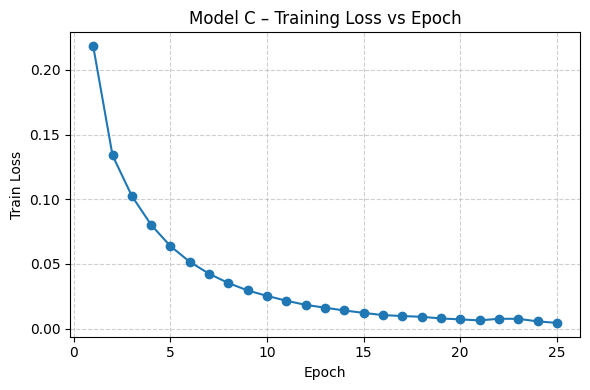

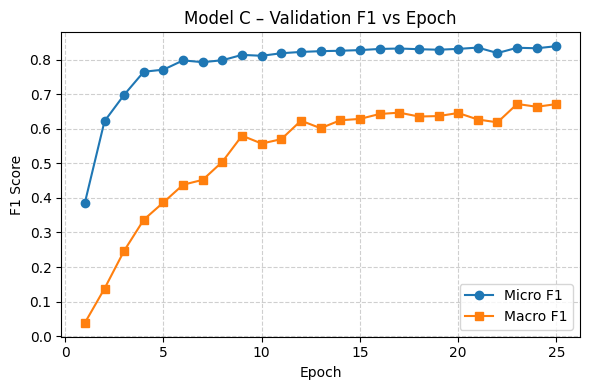

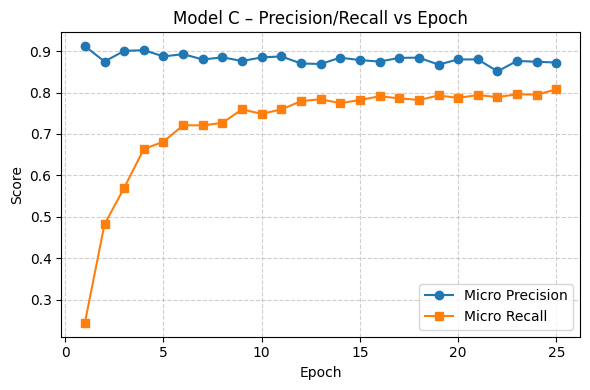

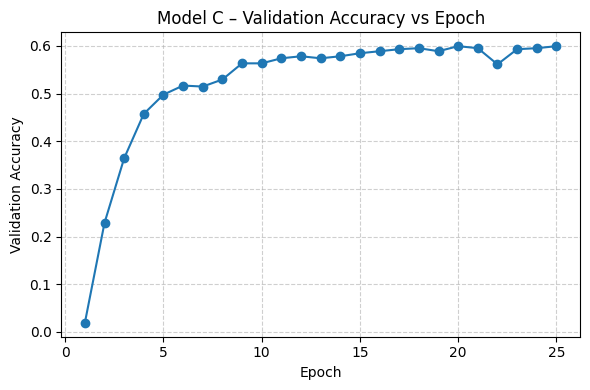

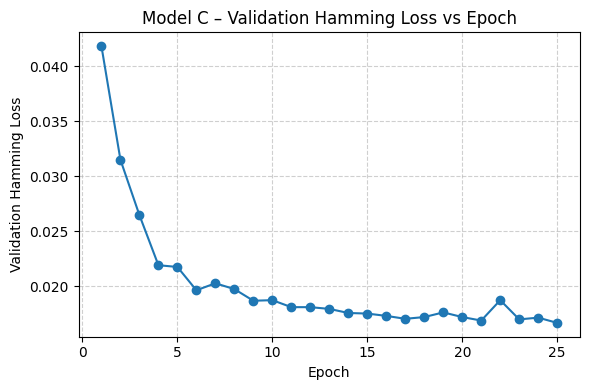


STEP 20.5: Comparing Model C (summarized ClinicalBERT) with Logistic + TF-IDF baseline.

=== Model C (Summarized ClinicalBERT) vs Logistic Regression + TF-IDF ===
      Metric  ModelC_HierBERT  LogReg_TFIDF
    Micro F1         0.838710      0.546341
    Macro F1         0.671219      0.138351
Hamming Loss         0.016684      0.034481


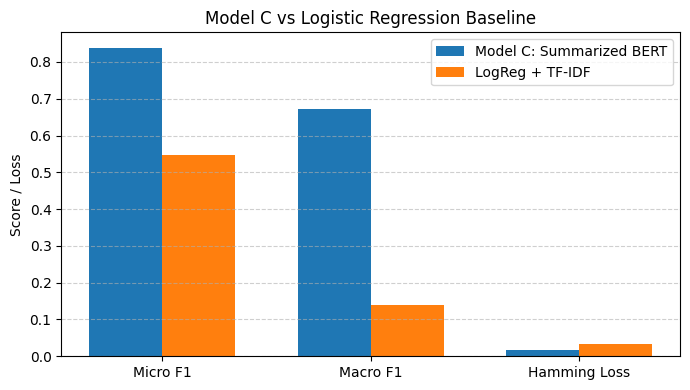

In [36]:
print("\nSTEP 20: Training ClinicalBERT on multi-level hierarchical summarized text (Model C).")

if not all(name in globals() for name in ["X_train_raw", "X_val_raw", "y_train", "y_val"]):
    print("Train/Val variables not found in memory. Loading from saved summarized CSV...")

    summarized_csv_path = "mtsamples_hierarchical_summarized_multilabel.csv"
    summarized_df = pd.read_csv(summarized_csv_path)

    non_label_cols = ["transcription_raw", "summarized_for_bert"]
    label_columns = [c for c in summarized_df.columns if c not in non_label_cols]

    print("Label columns detected:", label_columns)

    X_raw_all  = summarized_df["transcription_raw"].fillna("").values
    X_summ_all = summarized_df["summarized_for_bert"].fillna("").values
    y_all      = summarized_df[label_columns].values

    X_train_raw, X_val_raw, X_train_summ, X_val_summ, y_train, y_val = train_test_split(
        X_raw_all,
        X_summ_all,
        y_all,
        test_size=0.2,
        random_state=RANDOM_STATE,
    )

    print("New train/val split created from summarized CSV.")
    print("X_train_raw shape:", X_train_raw.shape)
    print("X_train_summ shape:", X_train_summ.shape)
    print("y_train shape:", y_train.shape)
    print("X_val_raw shape:", X_val_raw.shape)
    print("X_val_summ shape:", X_val_summ.shape)
    print("y_val shape:", y_val.shape)

else:
    print("Train/Val variables already exist in memory. Using existing split.")

if "X_train_summ" not in globals() or "X_val_summ" not in globals():
    print("WARNING: X_train_summ / X_val_summ not found. Using cleaned raw text as input.")
    X_train_summ = [clean_medical_text(t) for t in X_train_raw]
    X_val_summ   = [clean_medical_text(t) for t in X_val_raw]

class ClinicalDatasetSummarized(Dataset):
    """
    Dataset variant for Model C:
    - Input: pre-summarized & cleaned text (summarized_for_bert)
    - labels: multi-hot vectors as before
    - This does NOT depend on summarized_text_map; it directly uses X_summ arrays.
    """

    def __init__(self, texts_summ, labels, tokenizer, max_len=512):
        self.texts_summ = list(texts_summ)
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts_summ)

    def __getitem__(self, idx):
        text_for_bert = str(self.texts_summ[idx])
        labels = torch.tensor(self.labels[idx], dtype=torch.float)

        encoded = self.tokenizer.encode_plus(
            text_for_bert,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding="max_length",
            return_attention_mask=True,
            return_token_type_ids=False,
        )

        input_ids = encoded["input_ids"]
        attention_mask = encoded["attention_mask"]

        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "attention_mask": torch.tensor(attention_mask, dtype=torch.long),
            "labels": labels,
        }

print("Checkpoint 20.1: Creating train/val datasets & loaders for summarized text (Model C).")

train_dataset_summ = ClinicalDatasetSummarized(
    X_train_summ,
    y_train,
    tokenizer,
    max_len=MAX_LEN,
)
val_dataset_summ = ClinicalDatasetSummarized(
    X_val_summ,
    y_val,
    tokenizer,
    max_len=MAX_LEN,
)

train_loader_summ = DataLoader(train_dataset_summ, batch_size=BATCH_SIZE, shuffle=True)
val_loader_summ   = DataLoader(val_dataset_summ,   batch_size=BATCH_SIZE, shuffle=False)

print("Number of training batches (summarized):", len(train_loader_summ))
print("Number of validation batches (summarized):", len(val_loader_summ))

print("\nCheckpoint 20.2: Initializing ClinicalBERT model for summarized input (Model C).")

model_summ = ClinicalBertClassifier(MODEL_NAME, num_labels=num_labels).to(device)

criterion_summ = nn.BCEWithLogitsLoss()
optimizer_summ = AdamW(model_summ.parameters(), lr=LR)

print("\nCheckpoint 20.3: Starting training for Model C (summarized text).")

train_losses_summ         = []
val_micro_f1s_summ        = []
val_macro_f1s_summ        = []
val_micro_precisions_summ = []
val_micro_recalls_summ    = []
val_accuracies_summ       = []
val_hamming_losses_summ   = []

best_hamming_loss_summ = float("inf")
best_model_state_summ  = None
best_epoch_summ        = -1
patience_counter_summ  = 0

for epoch in range(EPOCHS):
    print(f"\n========== [Model C] Epoch {epoch + 1}/{EPOCHS} ==========")

    train_loss = train_one_epoch(model_summ, train_loader_summ, optimizer_summ, criterion_summ, device)
    train_losses_summ.append(train_loss)
    print(f"[Model C] Train Loss: {train_loss:.4f}")

    metrics = validate(model_summ, val_loader_summ, device)
    val_micro_f1s_summ.append(metrics["micro_f1"])
    val_macro_f1s_summ.append(metrics["macro_f1"])
    val_micro_precisions_summ.append(metrics["micro_precision"])
    val_micro_recalls_summ.append(metrics["micro_recall"])
    val_accuracies_summ.append(metrics["accuracy"])
    val_hamming_losses_summ.append(metrics["hamming_loss"])

    print("[Model C] Validation Metrics:")
    for k, v in metrics.items():
        print(f"  {k}: {v:.4f}")

    current_hamming_loss = metrics["hamming_loss"]

    if current_hamming_loss < best_hamming_loss_summ:
        best_hamming_loss_summ = current_hamming_loss
        best_model_state_summ  = model_summ.state_dict()
        best_epoch_summ        = epoch + 1
        patience_counter_summ  = 0
        print(f"** [Model C] New best Hamming loss: {best_hamming_loss_summ:.4f} at epoch {best_epoch_summ}. **")
    else:
        patience_counter_summ += 1
        print(f"[Model C] No improvement in Hamming loss. Patience {patience_counter_summ}/{PATIENCE}.")

    if patience_counter_summ >= PATIENCE:
        print(f"\n[Model C] Early stopping triggered after {epoch + 1} epochs.")
        break

if best_model_state_summ is not None:
    model_summ.load_state_dict(best_model_state_summ)
    print(f"\n[Model C] Loaded best model state from epoch {best_epoch_summ} (Hamming loss = {best_hamming_loss_summ:.4f}).")
else:
    print("[Model C] WARNING: best_model_state_summ is None.")

import matplotlib.pyplot as plt
import numpy as np

epochs_c = np.arange(1, len(train_losses_summ) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs_c, train_losses_summ, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Model C – Training Loss vs Epoch")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_c, val_micro_f1s_summ, marker="o", label="Micro F1")
plt.plot(epochs_c, val_macro_f1s_summ, marker="s", label="Macro F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Model C – Validation F1 vs Epoch")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_c, val_micro_precisions_summ, marker="o", label="Micro Precision")
plt.plot(epochs_c, val_micro_recalls_summ, marker="s", label="Micro Recall")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Model C – Precision/Recall vs Epoch")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_c, val_accuracies_summ, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Model C – Validation Accuracy vs Epoch")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs_c, val_hamming_losses_summ, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Validation Hamming Loss")
plt.title("Model C – Validation Hamming Loss vs Epoch")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

print("\nSTEP 20.5: Comparing Model C (summarized ClinicalBERT) with Logistic + TF-IDF baseline.")

if best_epoch_summ is not None and best_epoch_summ > 0:
    modelC_best_micro_f1 = val_micro_f1s_summ[best_epoch_summ - 1]
    modelC_best_macro_f1 = val_macro_f1s_summ[best_epoch_summ - 1]
else:
    modelC_best_micro_f1 = val_micro_f1s_summ[-1]
    modelC_best_macro_f1 = val_macro_f1s_summ[-1]

comparison_C_vs_logreg = pd.DataFrame({
    "Metric": ["Micro F1", "Macro F1", "Hamming Loss"],
    "ModelC_HierBERT": [
        modelC_best_micro_f1,
        modelC_best_macro_f1,
        best_hamming_loss_summ,
    ],
    "LogReg_TFIDF": [
        baseline_micro_f1,
        baseline_macro_f1,
        baseline_hamming_loss,
    ],
})

print("\n=== Model C (Summarized ClinicalBERT) vs Logistic Regression + TF-IDF ===")
print(comparison_C_vs_logreg.to_string(index=False))

metrics = comparison_C_vs_logreg["Metric"].values
modelC_values = comparison_C_vs_logreg["ModelC_HierBERT"].values
logreg_values = comparison_C_vs_logreg["LogReg_TFIDF"].values

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(7,4))
plt.bar(x - width/2, modelC_values, width, label="Model C: Summarized BERT")
plt.bar(x + width/2, logreg_values, width, label="LogReg + TF-IDF")
plt.xticks(x, metrics)
plt.ylabel("Score / Loss")
plt.title("Model C vs Logistic Regression Baseline")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


#  **Conclusion**

## Key Findings

### 1. Logistic Regression + TF-IDF Baseline
- Served as a strong classical baseline
- Achieved reasonable Micro-F1 but poor Macro-F1 due to severe class imbalance

### 2. Model A (Sentence-Priority BERT)
- Used priority-based sentence extraction
- Outperformed the baseline
- Was computationally efficient
- Outperformed Model B (intro+conclusion 256+256)

### 3. Model B (Intro+Conclusion 256+256)
- Used beginning + ending segments of text
- Motivated by medical note structure
- Performance was weaker than Model A
- Not included in the final results

### 4. Model C (T5 Summarization → ClinicalBERT)
- Best-performing method in this notebook
- Hierarchical summarization preserved semantic structure
- Compressed long notes without losing clinical information
- Produced strong Micro-F1 and lower Hamming Loss